In [2]:
library(Seurat)
library(Matrix)
library(flexclust)
library(FNN)
library(base)
library(ggplot2)
library(GMCM)
library(vegan)
library(gwDist)
# library(bigutilsr)

clustering

In [3]:
# dirs="/data02/tguo/space_batch_effect/simulate/"
# batch_sim="_1_2"
# types="_3batch_types5"
# B=3
# embed1_file=paste(dirs,"gtt_output/AGC_embed",batch_sim,types,"_xent.csv",sep="")
# embed2_file=paste(dirs,"methods/seurat_mat",batch_sim,types,".csv",sep="")
# embed3_file=paste(dirs,"methods/harmony_mat",batch_sim,types,".csv",sep="")
# meta_file=c()
# mat_file=c()
# coord_file=c()
# for(i in 1:B){
#     meta_file=c(meta_file,paste(dirs,"gtt_input/meta",i,batch_sim,types,".csv",sep=""))
#     mat_file=c(mat_file,paste(dirs,"gtt_input/feat",i,batch_sim,types,".csv",sep=""))
#     coord_file=c(coord_file,paste(dirs,"gtt_input/coord",i,batch_sim,types,".csv",sep=""))
# }
# flags=paste(batch_sim,types,sep="")

In [5]:
# dirs="/data02/tguo/space_batch_effect/human_DLPFC_10x/"
# samples=c("151507","151669","151673")

# meta_file=c()
# mat_file=c()
# coord_file=c()
# flags=""
# for(i in 1:length(samples)){
#     meta_file=c(meta_file,paste(dirs,"input/",samples[i],"_label.txt",sep=""))
#     mat_file=c(mat_file,paste(dirs,"input/",samples[i],"_features.txt",sep=""))
#     coord_file=c(coord_file,paste(dirs,"input/",samples[i],"_positions.txt",sep=""))
#     flags=paste(flags,"_",samples[i],sep="")
# }
# embed1_file=paste(dirs,"gtt_output/AGC_embed",flags,"_xent.csv",sep="")
# embed2_file=paste(dirs,"methods/seurat_mat",flags,".txt",sep="")
# embed3_file=paste(dirs,"methods/harmony_mat",flags,".txt",sep="")

In [2]:
dirs="/data02/tguo/space_batch_effect/mouse_brain/"
samples=c("anterior1","anterior2")
sample="anterior"
embed1_file=paste(dirs,"gtt_output/AGC_embed_",samples[1],"_",samples[2],".csv",sep="")
embed2_file=paste(dirs,"methods/seurat_mat_",samples[1],"_",samples[2],".txt",sep="")
embed3_file=paste(dirs,"methods/harmony_mat_",samples[1],"_",samples[2],".txt",sep="")
meta_file=c()
mat_file=c()
coord_file=c()
for(i in 1:length(samples)){
    mat_file=c(mat_file,paste(dirs,"gtt_input/",samples[i],"_mat.csv",sep=""))
    coord_file=c(coord_file,paste(dirs,"gtt_input/",samples[i],"_coord.csv",sep=""))
    meta_file=c(meta_file,paste(dirs,"gtt_input/",sample,"_meta.csv",sep=""))
}


Warning message in PrepDR(object = object, features = features, verbose = verbose):
“The following 200 features requested have zero variance (running reduction without them): Gene9, Gene11, Gene13, Gene15, Gene20, Gene21, Gene23, Gene27, Gene28, Gene29, Gene36, Gene39, Gene40, Gene41, Gene48, Gene52, Gene54, Gene55, Gene56, Gene57, Gene58, Gene60, Gene62, Gene63, Gene67, Gene68, Gene69, Gene70, Gene73, Gene74, Gene75, Gene76, Gene77, Gene83, Gene87, Gene89, Gene90, Gene92, Gene95, Gene97, Gene101, Gene103, Gene107, Gene111, Gene113, Gene117, Gene120, Gene122, Gene125, Gene128, Gene138, Gene139, Gene140, Gene141, Gene142, Gene145, Gene147, Gene149, Gene154, Gene155, Gene163, Gene165, Gene171, Gene173, Gene174, Gene177, Gene179, Gene180, Gene184, Gene185, Gene186, Gene187, Gene189, Gene194, Gene195, Gene197, Gene199, Gene201, Gene204, Gene206, Gene208, Gene210, Gene214, Gene215, Gene216, Gene220, Gene226, Gene231, Gene233, Gene235, Gene236, Gene242, Gene245, Gene247, Gene248, Gene249, Ge

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 846
Number of edges: 36524

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8013
Number of communities: 6
Elapsed time: 0 seconds


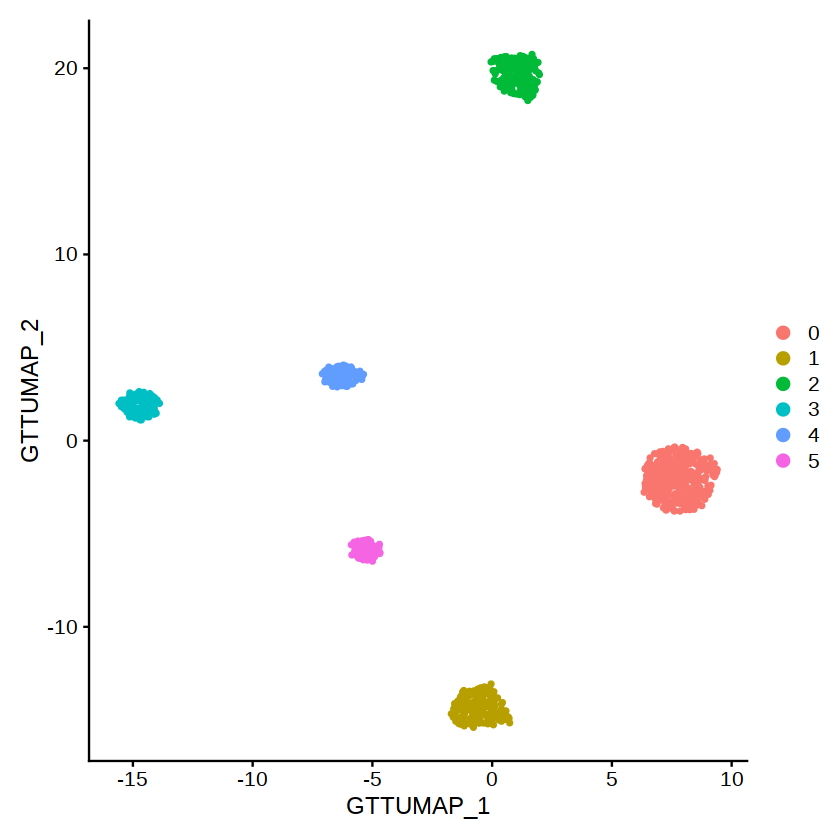

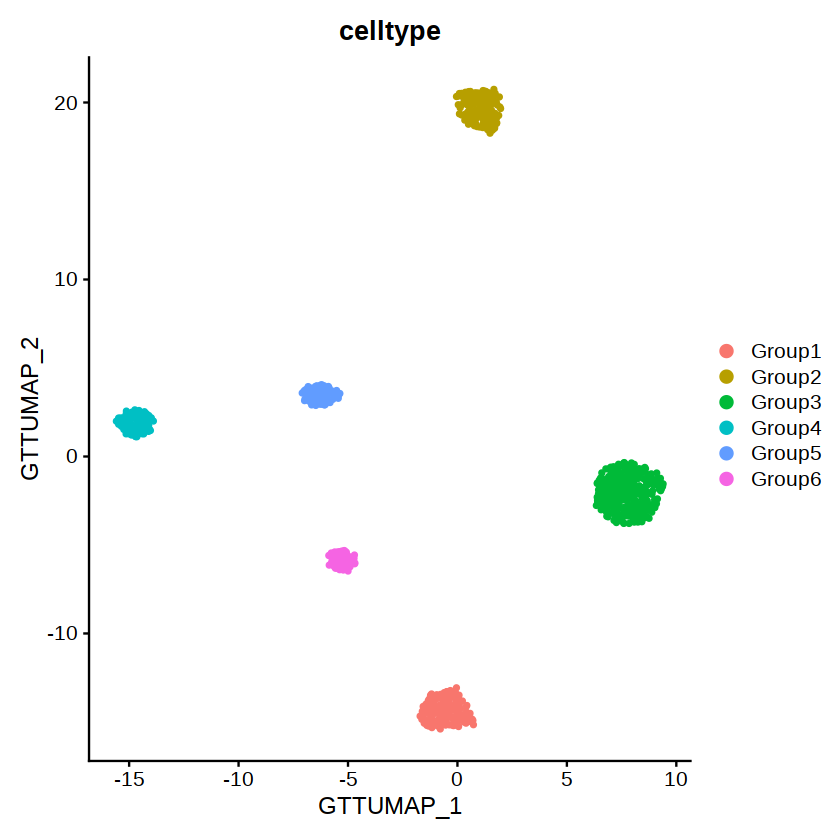

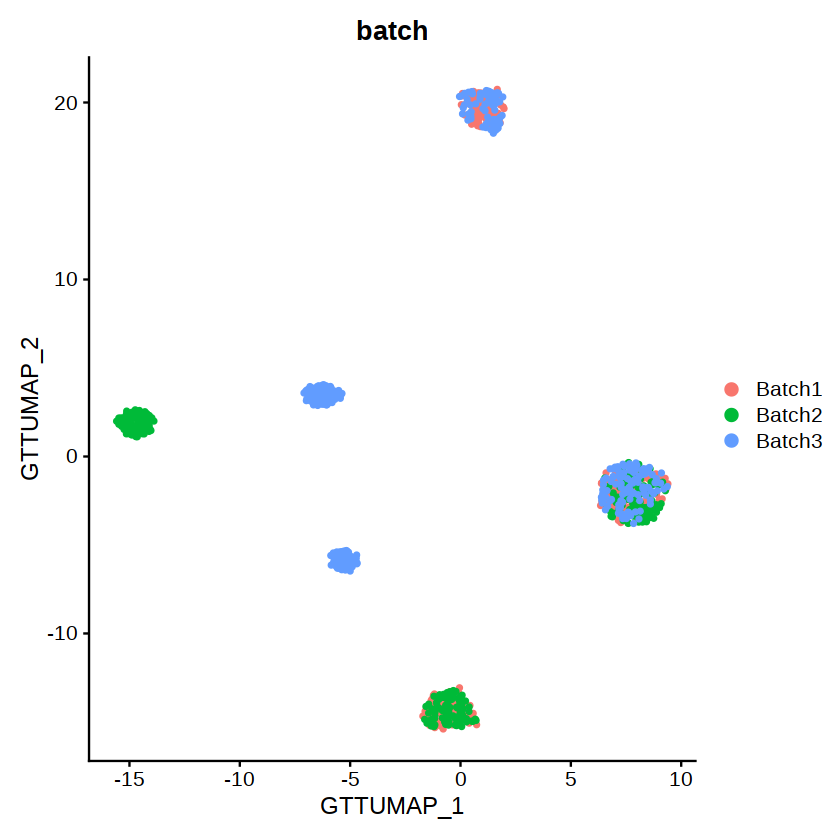

In [4]:
embed1=read.csv(embed1_file,header=T,row.names=1,sep=',')
embed2=read.csv(embed2_file,header=T,row.names=1,sep=',')
embed3=read.csv(embed3_file,header=T,row.names=1,sep=',')
meta=read.csv(meta_file[1],header=T,row.names=1,sep=',')
mat=read.csv(mat_file[1],header=T,row.names=1,sep=',')
for(i in 2:length(meta_file)){
    meta<-rbind(meta,read.csv(meta_file[i],header=T,row.names=1,sep=','))
    mat<-rbind(mat,read.csv(mat_file[i],header=T,row.names=1,sep=','))
}        
mat=as.matrix(t(mat))
mat=as(mat,'dgCMatrix')
meta=meta[colnames(mat),]
obj<-CreateSeuratObject(counts=mat,meta.data=meta)
obj[['GTT']]<-CreateDimReducObject(embeddings=as.matrix(embed1), key = "GTT_", assay = DefaultAssay(obj))
obj[['Seurat']]<-CreateDimReducObject(embeddings=as.matrix(embed2), key = "Seurat_", assay = DefaultAssay(obj))
obj[['Harmony']]<-CreateDimReducObject(embeddings=as.matrix(embed3), key = "Harmony_", assay = DefaultAssay(obj))
VariableFeatures(obj)<-rownames(obj)
obj@assays$RNA@scale.data=as.matrix(mat)
obj<-RunPCA(obj,npcs=30,features=rownames(mat))
obj<-RunUMAP(obj, dims=1:10)
obj<-RunUMAP(obj, dims=3:dim(embed1)[2],reduction='GTT',reduction.name="gtt.umap",reduction.key="GTTUMAP_")
obj<-FindNeighbors(obj,reduction="GTT",dims=3:dim(embed1)[2])
obj<-FindClusters(obj,resolution = 1.0)
clusters=data.frame(cbind(obj$seurat_clusters,obj$batch))
colnames(clusters)<-c('clusters','batch')
write.csv(clusters,paste(dirs,"gtt_output/coordinate_file/gtt_clusters_",flags,".csv",sep=""))
DimPlot(obj,reduction="gtt.umap")
DimPlot(obj,group.by="celltype",reduction="gtt.umap")
DimPlot(obj,group.by="batch",reduction="gtt.umap")

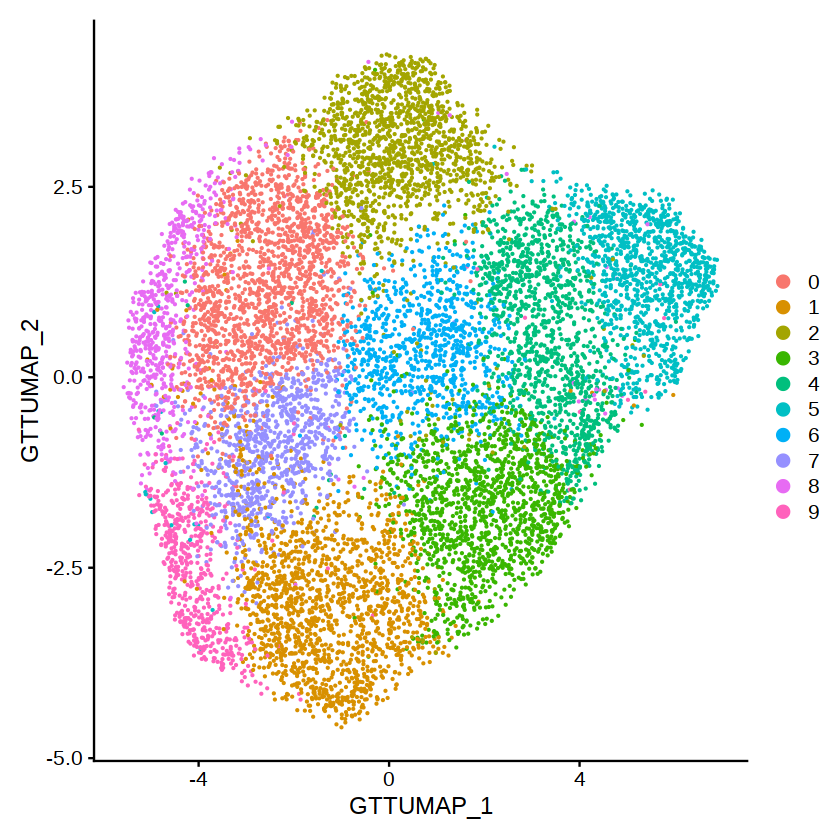

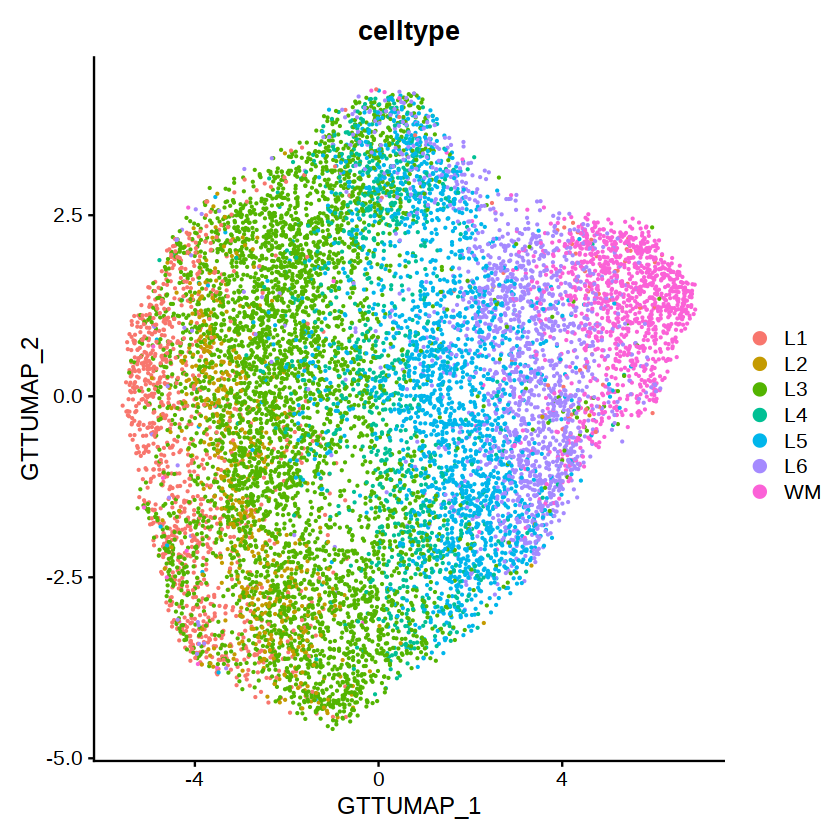

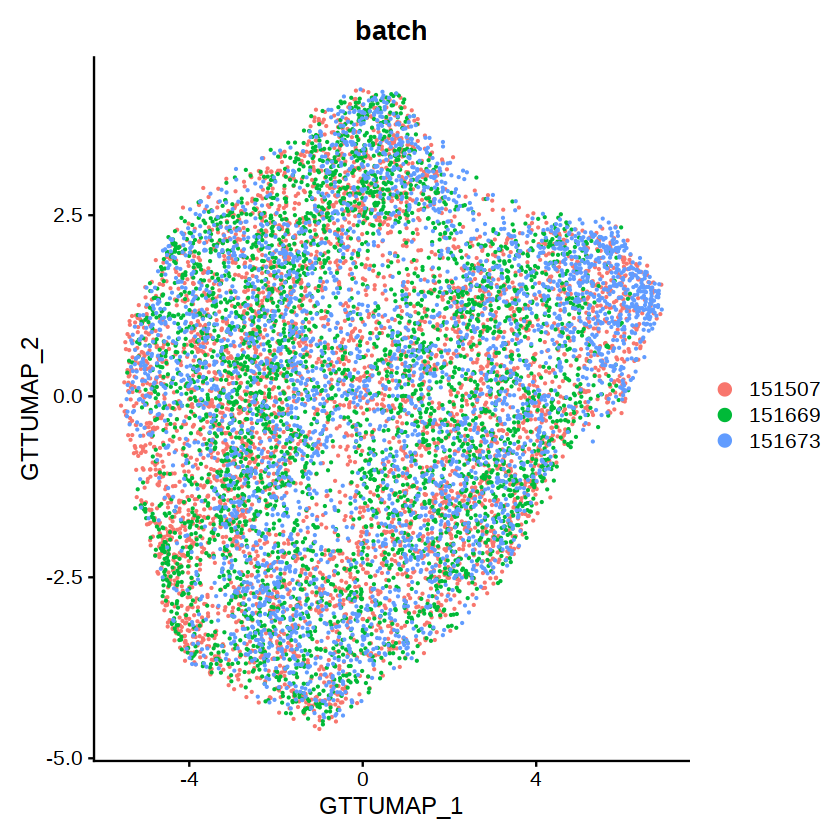

In [7]:
write.csv(clusters,paste(dirs,"gtt_output/coordinate_file/gtt_clusters_",flags,".csv",sep=""))
DimPlot(obj,reduction="gtt.umap")
DimPlot(obj,group.by="celltype",reduction="gtt.umap")
DimPlot(obj,group.by="batch",reduction="gtt.umap")

18:22:42 UMAP embedding parameters a = 0.9922 b = 1.112

18:22:42 Read 825 rows and found 30 numeric columns

18:22:42 Using Annoy for neighbor search, n_neighbors = 30

18:22:42 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

18:22:42 Writing NN index file to temp file /tmp/RtmpT3PBA1/file67d93138499d

18:22:42 Searching Annoy index using 1 thread, search_k = 3000

18:22:42 Annoy recall = 100%

18:22:43 Commencing smooth kNN distance calibration using 1 thread

18:22:43 Found 4 connected components, 
falling back to 'spca' initialization with init_sdev = 1

18:22:43 Initializing from PCA

18:22:43 PCA: 2 components explained 76.3% variance

18:22:43 Commencing optimization for 500 epochs, with 34304 positive edges

18:22:47 Optimization finished

Computing nearest nei

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 825
Number of edges: 40511

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8099
Number of communities: 6
Elapsed time: 0 seconds


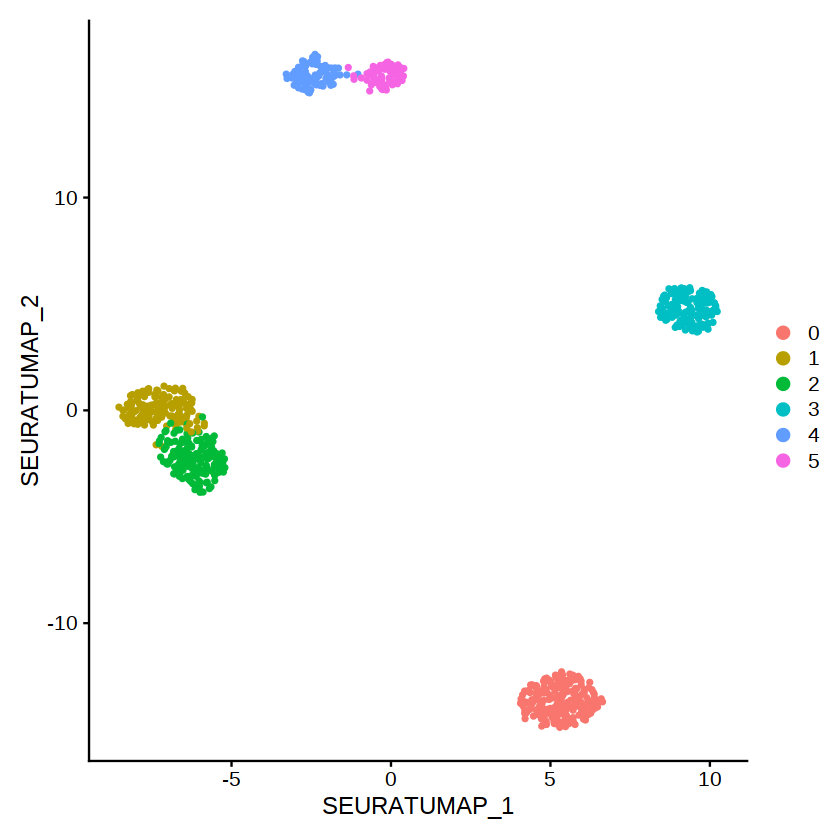

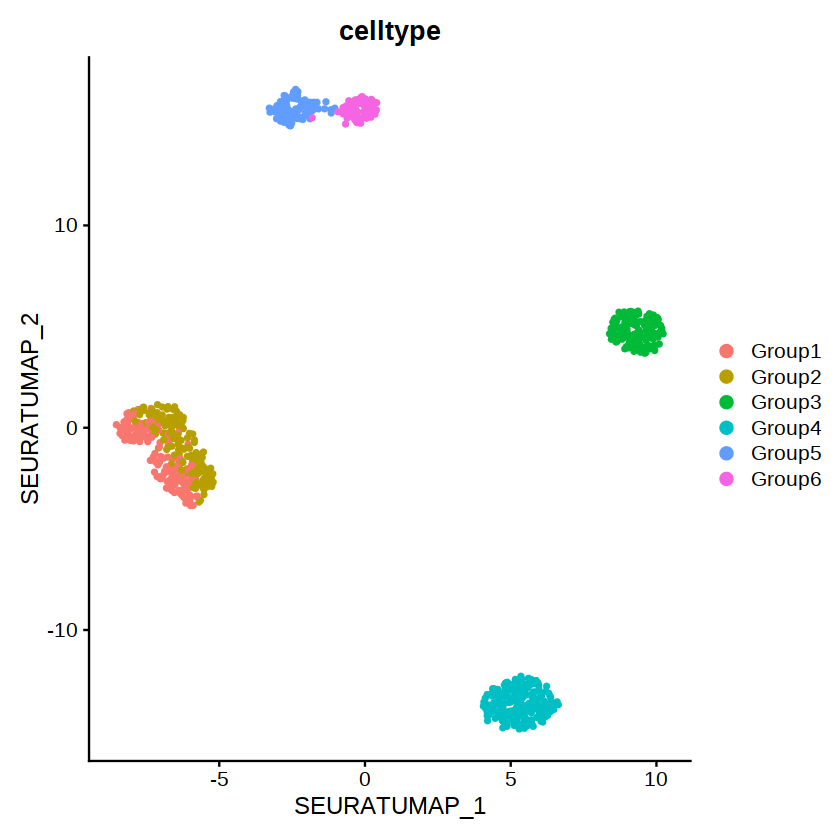

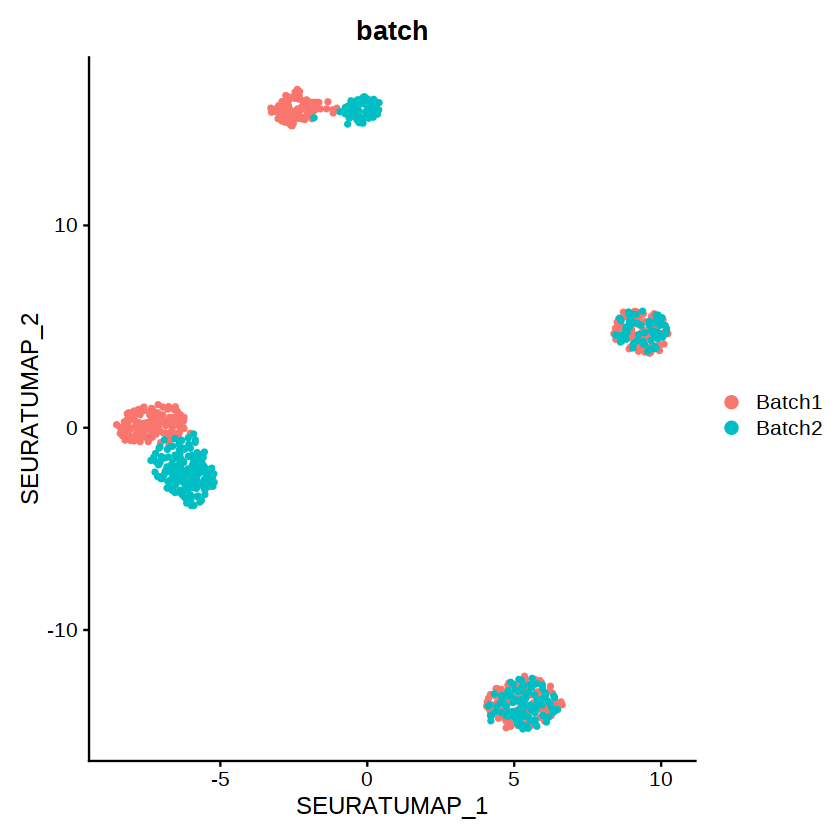

In [5]:
obj<-RunUMAP(obj, dims=1:dim(embed2)[2],reduction='Seurat',reduction.name="seurat.umap",reduction.key="SEURATUMAP_")
obj<-FindNeighbors(obj,reduction="Seurat",dims=1:30)
obj<-FindClusters(obj,resolution = 1.0)
DimPlot(obj,reduction="seurat.umap")
DimPlot(obj,reduction="seurat.umap",group.by="celltype")
DimPlot(obj,reduction="seurat.umap",group.by="batch")
clusters=data.frame(cbind(obj$seurat_clusters,obj$batch))
colnames(clusters)<-c('clusters','batch')
write.csv(clusters,paste(dirs,"gtt_output/coordinate_file/seurat_clusters",batch_sim,types,".csv",sep=""))
# write.csv(clusters,paste(dirs,"gtt_output/coordinate_file/seurat_clusters_",samples[1],"_",samples[2],".csv",sep=""))


18:22:49 UMAP embedding parameters a = 0.9922 b = 1.112

18:22:49 Read 825 rows and found 30 numeric columns

18:22:49 Using Annoy for neighbor search, n_neighbors = 30

18:22:49 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

18:22:49 Writing NN index file to temp file /tmp/RtmpT3PBA1/file67d96777f0e8

18:22:49 Searching Annoy index using 1 thread, search_k = 3000

18:22:50 Annoy recall = 100%

18:22:50 Commencing smooth kNN distance calibration using 1 thread

18:22:51 Found 5 connected components, 
falling back to 'spca' initialization with init_sdev = 1

18:22:51 Initializing from PCA

18:22:51 PCA: 2 components explained 79.33% variance

18:22:51 Commencing optimization for 500 epochs, with 33488 positive edges

18:22:54 Optimization finished

Computing nearest ne

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 825
Number of edges: 39118

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9259
Number of communities: 6
Elapsed time: 0 seconds


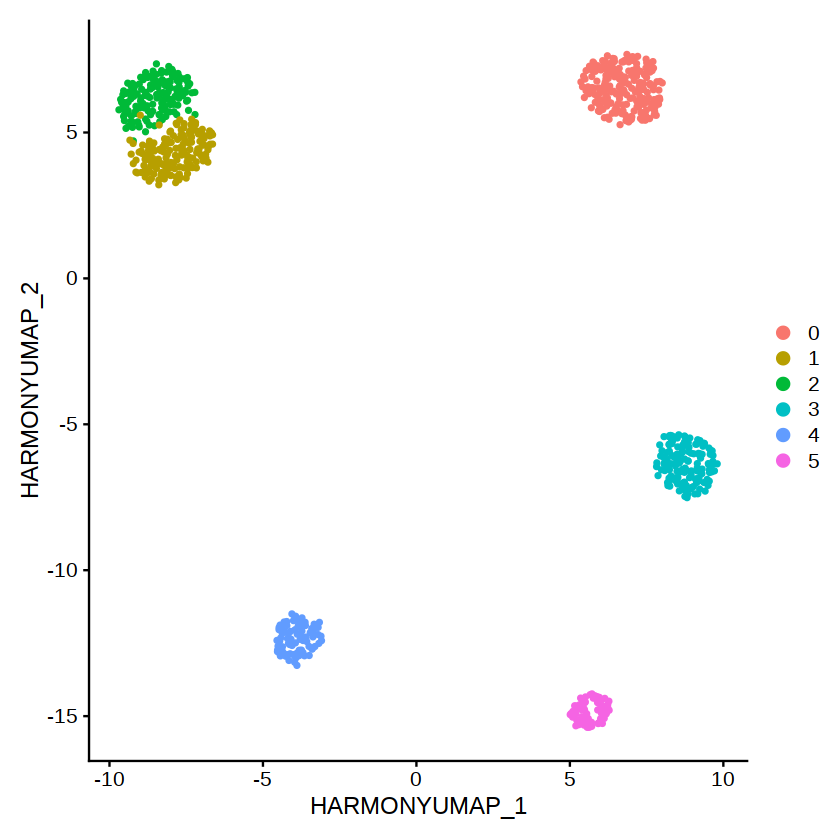

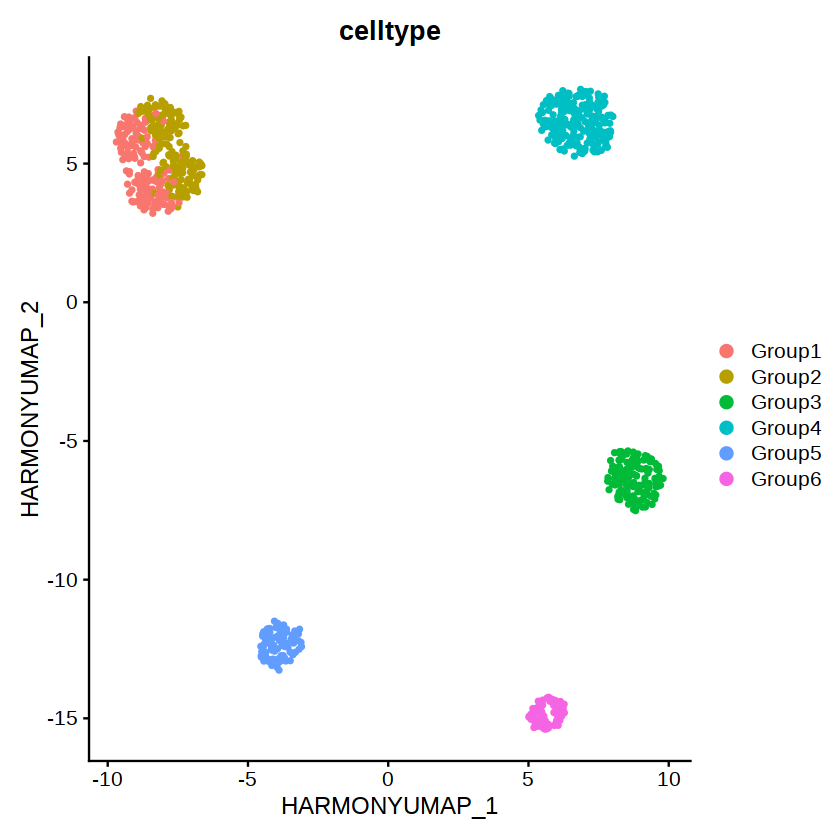

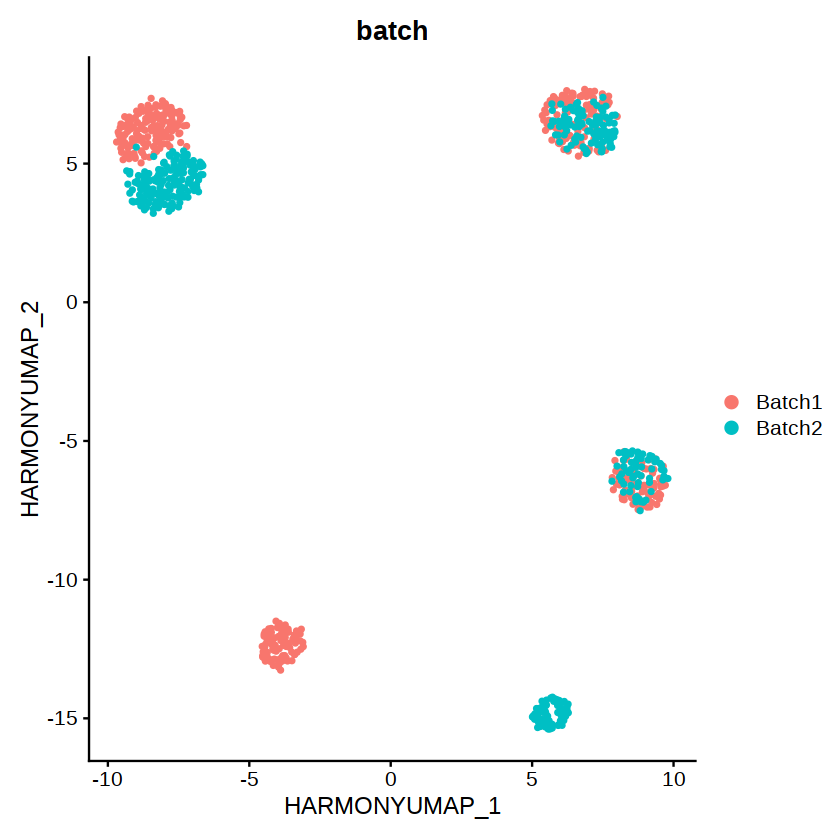

In [6]:
obj<-RunUMAP(obj, dims=1:dim(embed3)[2],reduction='Harmony',reduction.name="harmony.umap",reduction.key="HARMONYUMAP_")
obj<-FindNeighbors(obj,reduction="Harmony",dims=1:30)
obj<-FindClusters(obj,resolution = 0.4)
DimPlot(obj,reduction="harmony.umap")
DimPlot(obj,reduction="harmony.umap",group.by="celltype")
DimPlot(obj,reduction="harmony.umap",group.by="batch")
clusters=data.frame(cbind(obj$seurat_clusters,obj$batch))
colnames(clusters)<-c('clusters','batch')
write.csv(clusters,paste(dirs,"gtt_output/coordinate_file/harmony_clusters",batch_sim,types,".csv",sep=""))
# write.csv(clusters,paste(dirs,"gtt_output/coordinate_file/harmony_clusters_",samples[1],"_",samples[2],".csv",sep=""))


In [ ]:
obj<-FindNeighbors(obj,reduction="GTT",dims=3:dim(embed1)[2])
obj<-FindClusters(obj,resolution = 1.0)
DimPlot(obj,reduction="gtt.umap",label=T)
DimPlot(obj,reduction="gtt.umap",group.by="celltype",label=T)
DimPlot(obj,reduction="gtt.umap",group.by="batch",label=T)
clusters=data.frame(cbind(obj$seurat_clusters,obj$batch))
colnames(clusters)<-c('clusters','batch')
write.csv(clusters,paste(dirs,"gtt_output/coordinate_file/gtt_clusters",batch_sim,types,".csv",sep=""))
# write.csv(clusters,paste(dirs,"gtt_output/coordinate_file/gtt_clusters_",samples[1],"_",samples[2],".csv",sep=""))

linear transformation

In [7]:
generalized_procrustes_analysis<-function(X, Y, pi){
    tX=t(as.matrix(rowSums(pi)))%*%X
    tY=t(as.matrix(colSums(pi)))%*%Y
    X=X-tX[rep(1,dim(X)[1]),]
    Y=Y-tY[rep(1,dim(Y)[1]),]
    H=t(Y)%*%(t(pi)%*%X)
    a=svd(H)
    S=a$d
    U=a$u
    Vt=t(a$v)
    R=t(Vt)%*%t(U)
    Y=t(R%*%t(Y))
    X=X+tX[rep(1,dim(X)[1]),]
    Y=Y+tX[rep(1,dim(Y)[1]),]
    return(list(X,Y))
}

In [6]:
clust='5'
na=rownames(clusters)[clusters==clust]
a=embed[na,]
embed1=a[meta[na,2]==ub[1],3:dim(embed)[2]]
embed2=a[meta[na,2]==ub[ub_id],3:dim(embed)[2]]
gtt_dist=dist2(embed1,embed2)
gtt_pi=1/gtt_dist
coord1=Coord1[rownames(gtt_dist),]
coord2=Coord2[colnames(gtt_dist),]
new_coord=rbind(coord1,coord2)
ggplot(new_coord,aes(x,y,color=batch))+geom_point()
pi=read.csv(paste(dirs,"gtt_output/coordinate_file/gwd_pi_Batch1_Batch2_",clust,batch_sim,types,".csv",sep=""),row.names=1,header=T)
pi=pi[rownames(coord1),rownames(coord2)]
new_coord2=coord2
idx=c()
for(i in 1:dim(pi)[2]){
    idx=which(pi[,i]!=0)
    new_coord2[i,1:2]=colMeans(coord1[idx,1:2])
}
new_coord=rbind(coord1,new_coord2)
ggplot(new_coord,aes(x,y,color=batch))+geom_point()

# pi1=read.csv(paste(dirs,"methods/paste_pi",batch_sim,types,".csv",sep=""),row.names=1,header=T)
# pi1=pi1[rownames(coord1),rownames(coord2)]
# trans=colMeans(coord1[,1:2])-colMeans(coord2[,1:2])
# scale=apply(X=coord1[,1:2], MARGIN=2, FUN=sd)/apply(X=coord2[,1:2], MARGIN=2, FUN=sd)
# coord2[,1:2]=t(t(coord2[,1:2])+trans)
# coord2[,1:2]=t(t(coord2[,1:2])*scale)
# new_coord=rbind(coord1,coord2)
# ggplot(new_coord,aes(x,y,color=batch))+geom_point()
# out=generalized_procrustes_analysis(as.matrix(coord1[,1:2]),as.matrix(coord2[,1:2]),as.matrix(pi))
# coord1[,1:2]=out[[1]]
# coord2[,1:2]=out[[2]]
# new_coord=rbind(coord1,coord2)
# ggplot(new_coord,aes(x,y,color=batch))+geom_point()
# KNN=1
# a=get.knnx(as.matrix(embed1),as.matrix(embed2),k=KNN)
# knn21=a$nn.index
# a=get.knnx(as.matrix(embed2),as.matrix(embed1),k=KNN)
# knn12=a$nn.index
# a=which((knn21[knn12[,1],1]-seq(1,dim(embed1)[1]))==0)
# coord1_=coord1[a,]
# coord2_=coord2[knn12[a,1],]
# # coord1_=coord1[a,]
# # coord2_=coord2[knn12[a,1],]

# PROCRUSTES=procrustes(as.matrix(coord1_[,1:2]),as.matrix(coord2_[,1:2]),scale=FALSE)
# coord2_[,1:2]=fitted(PROCRUSTES)[,1:2]
# coord_=rbind(coord1_,coord2_)
# ggplot(coord_,aes(x,y,color=batch))+geom_point(size=3)
# new_coord2[,1:2]=predict(PROCRUSTES, coord2[,1:2])
# new_coord=rbind(coord1,new_coord2)
# ggplot(new_coord,aes(x,y,color=batch))+geom_point()
# id1=which(pi!=0)%%dim(pi)[1]
# id2=which(pi!=0)%/%dim(pi)[1]+1
# id1[id1==0]=dim(pi)[1]

ERROR: Error in embed[na, ]: object of type 'closure' is not subsettable


read in clustering by scanpy

In [18]:
# dirs="/data02/tguo/space_batch_effect/simulate/"
# batch="_1"
# types="_types5"
# flags=paste(batch,types,sep="")

# meta_file=c()
# coord_file=c()
# samples=c('1','2')
# for(i in 1:length(samples)){
#     meta_file=c(meta_file,paste(dirs,"gtt_input/meta",samples[i],flags,".csv",sep=""))
#     coord_file=c(coord_file,paste(dirs,"gtt_input/coord",samples[i],flags,".csv",sep=""))
# }
# embed1_file=paste(dirs,"gtt_output/AGC_embed",flags,"_xent.csv",sep="")
# embed1=read.csv(embed1_file,header=T,row.names=1,sep=',')
# meta=read.csv(meta_file[1],header=T,row.names=1,sep=',')
# for(i in 2:length(meta_file)){
#     meta<-rbind(meta,read.csv(meta_file[i],header=T,row.names=1,sep=','))
# }        
# if(dim(embed1)[2]==16){
#     znoise_dim=3
# }else{
#     znoise_dim=5
# }
# clust_cate='louvain'
# clusters=read.csv(paste(dirs,'metrics/',clust_cate,'_clust',flags,'.csv',sep=""),header=T,row.names=1,sep=',')
# clusters$celltype=meta[rownames(clusters),'celltype']
# clusters$batch=meta[rownames(clusters),'batch']

In [51]:
dirs="/data02/tguo/space_batch_effect/mouse_OB/"
samples=c("BGI","SlideV2","10X")
# samples=c("BGI","SlideV2","scRNA")
exp='_expression'
meta_file=c()
coord_file=c()
flags=""
for(i in 1:length(samples)){
    meta_file=c(meta_file,paste(dirs,"gtt_input/",samples[i],"_meta.csv",sep=""))
    coord_file=c(coord_file,paste(dirs,"gtt_input/",samples[i],"_coord.csv",sep=""))
    flags=paste(flags,"_",samples[i],sep="")
}
embed1_file=paste(dirs,"gtt_output/AGC_embed",flags,exp,"_xent.csv",sep="")
embed1=read.csv(embed1_file,header=T,row.names=1,sep=',')
meta=read.csv(meta_file[1],header=T,row.names=1,sep=',')
for(i in 2:length(meta_file)){
    meta<-rbind(meta,read.csv(meta_file[i],header=T,row.names=1,sep=','))
}        
if(dim(embed1)[2]==16){
    znoise_dim=3
}else{
    znoise_dim=5
}
clust_cate='louvain'

clusters=read.csv(paste(dirs,'metrics/',clust_cate,'_clust',flags,exp,'.csv',sep=""),header=T,row.names=1,sep=',')
embed1=embed1[rownames(meta),]

In [146]:
# dirs="/data02/tguo/space_batch_effect/human_DLPFC_10x/"
# samples=c('151507','151508','151509','151510','151669','151670','151671','151672','151673','151674','151675','151676')
# samples=samples[c(9,10,11,12)]
# meta_file=c()
# coord_file=c()
# flags=""
# flags1=samples[1];for(i in 2:length(samples)){flags1=paste(flags1,"-",samples[i],sep="")};flags1=paste(flags1,"_",sep="")
# for(i in 1:length(samples)){
#     meta_file=c(meta_file,paste(dirs,"gtt_input_scanpy/",flags1,samples[i],"_label.txt",sep=""))
#     coord_file=c(coord_file,paste(dirs,"gtt_input_scanpy/",flags1,samples[i],"_positions.txt",sep=""))
#     flags=paste(flags,"_",samples[i],sep="")
# }
# embed1_file=paste(dirs,"gtt_output/AGC_embed",flags,"_xent.csv",sep="")
# embed1=read.csv(embed1_file,header=T,row.names=1,sep=',')
# meta=read.csv(meta_file[1],header=T,row.names=1,sep=',')
# for(i in 2:length(meta_file)){
#     meta<-rbind(meta,read.csv(meta_file[i],header=T,row.names=1,sep=','))
# }        
# if(dim(embed1)[2]==16){
#     znoise_dim=3
# }else{
#     znoise_dim=5
# }
# clust_cate='louvain'
# clusters=read.csv(paste(dirs,'metrics/',clust_cate,'_clust',flags,'.csv',sep=""),header=T,row.names=1,sep=',')
# clusters1=read.csv(paste(dirs,'metrics/STAGATE_',clust_cate,'_clust',flags,'.csv',sep=""),header=T,row.names=1,sep=',')
# clusters2=read.csv(paste(dirs,'metrics/SEDR_',clust_cate,'_clust',flags,'.csv',sep=""),header=T,row.names=1,sep=',')
# clusters3=read.csv(paste(dirs,'metrics/seurat_',clust_cate,'_clust',flags,'.csv',sep=""),header=T,row.names=1,sep=',')
# clusters4=read.csv(paste(dirs,'metrics/harmony_',clust_cate,'_clust',flags,'.csv',sep=""),header=T,row.names=1,sep=',')

In [13]:
# dirs="/data02/tguo/space_batch_effect/mouse_brain/"
# samples=c("anterior1","anterior2")

# meta_file=c()
# coord_file=c()
# flags=""
# for(i in 1:length(samples)){
#     meta_file=c(meta_file,paste(dirs,"gtt_input/",samples[i],"_meta.csv",sep=""))
#     coord_file=c(coord_file,paste(dirs,"gtt_input/",samples[i],"_coord.csv",sep=""))
#     flags=paste(flags,"_",samples[i],sep="")
# }
# embed1_file=paste(dirs,"gtt_output/AGC_embed",flags,"_xent.csv",sep="")
# embed1=read.csv(embed1_file,header=T,row.names=1,sep=',')
# meta=read.csv(meta_file[1],header=T,row.names=1,sep=',')
# for(i in 2:length(meta_file)){
#     meta<-rbind(meta,read.csv(meta_file[i],header=T,row.names=1,sep=','))
# }        
# if(dim(embed1)[2]==16){
#     znoise_dim=3
# }else{
#     znoise_dim=5
# }
# clust_cate='louvain'
# clusters=read.csv(paste(dirs,'metrics/',clust_cate,'_clust',flags,'.csv',sep=""),header=T,row.names=1,sep=',')

In [40]:
# dirs="/data02/tguo/space_batch_effect/Hippo/"
# samples=c("10X_Normal","10X_DAPI","10X_FFPE")

# meta_file=c()
# coord_file=c()
# flags=""
# for(i in 1:length(samples)){
#     meta_file=c(meta_file,paste(dirs,"gtt_input/",samples[i],"_meta.csv",sep=""))
#     coord_file=c(coord_file,paste(dirs,"gtt_input/",samples[i],"_coord.csv",sep=""))
#     flags=paste(flags,"_",samples[i],sep="")
# }
# embed1_file=paste(dirs,"gtt_output/AGC_embed",flags,"_xent.csv",sep="")
# embed1=read.csv(embed1_file,header=T,row.names=1,sep=',')
# meta=read.csv(meta_file[1],header=T,row.names=1,sep=',')
# for(i in 2:length(meta_file)){
#     meta<-rbind(meta,read.csv(meta_file[i],header=T,row.names=1,sep=','))
# }        
# if(dim(embed1)[2]==16){
#     znoise_dim=3
# }else{
#     znoise_dim=5
# }
# clust_cate='louvain'
# clusters=read.csv(paste(dirs,'metrics/',clust_cate,'_clust',flags,'.csv',sep=""),header=T,row.names=1,sep=',')

In [52]:
########生成每个类别的文件#########
embed=embed1[,znoise_dim:dim(embed1)[2]]
Coord=read.csv(coord_file[1],header=T,row.names=1,sep=',')
# for(i in 2:length(coord_file)){
#     Coord=rbind(Coord,read.csv(coord_file[i],header=T,row.names=1,sep=','))
# }
for(i in 2:2){
    Coord=rbind(Coord,read.csv(coord_file[i],header=T,row.names=1,sep=','))
}
Coord=Coord[,c('x','y')]
ub=c('BGI','SlideV2','10X')
# ub=c('BGI','SlideV2','scRNA')
a=data.frame(x=seq(1,length(which(meta$batch==ub[3]))),y=seq(1,length(which(meta$batch==ub[3]))))
rownames(a)<-rownames(meta)[which(meta$batch==ub[3])]
Coord=rbind(Coord,a)
Coord<-merge(Coord,clusters,by='row.names')
rownames(Coord)<-Coord[,1]
Coord<-Coord[,-1]
Coord$celltype=meta[rownames(Coord),'celltype']
Coord$batch=meta[rownames(Coord),'batch']
colnames(Coord)[3]='clusters'
# Coord$clusters_STAGATE=clusters1[rownames(Coord),1]
# Coord$clusters_SEDR=clusters2[rownames(Coord),1]
# Coord$clusters_seurat=clusters3[rownames(Coord),1]
# Coord$clusters_harmony=clusters4[rownames(Coord),1]
# ub=unique(Coord$batch)
# ub=c('10X_Normal','10X_DAPI','10X_FFPE')
# ub=c('BGI','SlideV2')
cc=list()
c1=unique(Coord$clusters[Coord$batch==ub[1]])
for(i in 2:length(ub)){
    cc[[i-1]]=intersect(c1,unique(Coord$clusters[Coord$batch==ub[i]]))
}
coord1=Coord[Coord$batch==ub[1],]
for(bb in 1:length(cc)){
    uc=cc[[bb]]
    coord2=Coord[Coord$batch==ub[bb+1],]
    for(clust in uc){
        coord1_=coord1[coord1$clusters==clust,]
        coord2_=coord2[coord2$clusters==clust,]
        embed1_=embed[rownames(coord1_),]
        embed2_=embed[rownames(coord2_),]
        write.csv(embed1_,paste(dirs,"gtt_output/coordinate_file/embed_",ub[1],"_",clust,flags,".csv",sep=""))
        write.csv(embed2_,paste(dirs,"gtt_output/coordinate_file/embed_",ub[bb+1],"_",clust,flags,".csv",sep=""))
#         write.csv(coord1_,paste(dirs,"gtt_output/coordinate_file/coord_",ub[1],"_",clust,flags,".csv",sep=""))
#         write.csv(coord2_,paste(dirs,"gtt_output/coordinate_file/coord_",ub[bb+1],"_",clust,flags,".csv",sep=""))
        write.csv(embed1_,paste(dirs,"gtt_output/coordinate_file/coord_",ub[1],"_",clust,flags,".csv",sep=""))
        write.csv(embed2_,paste(dirs,"gtt_output/coordinate_file/coord_",ub[bb+1],"_",clust,flags,".csv",sep=""))
    }
}
write.csv(Coord[,c(3,4,5)],paste(dirs,"gtt_output/coordinate_file/gtt_clusters",flags,".csv",sep=""))

In [53]:
cc
clust_cate

[[1]]
[1] 0 4 5 1 2 3 7 6

[[2]]
[1] 0 4 5 1 2 3 6

[1] "louvain"

In [55]:
ub

[1] "BGI"     "SlideV2" "10X"

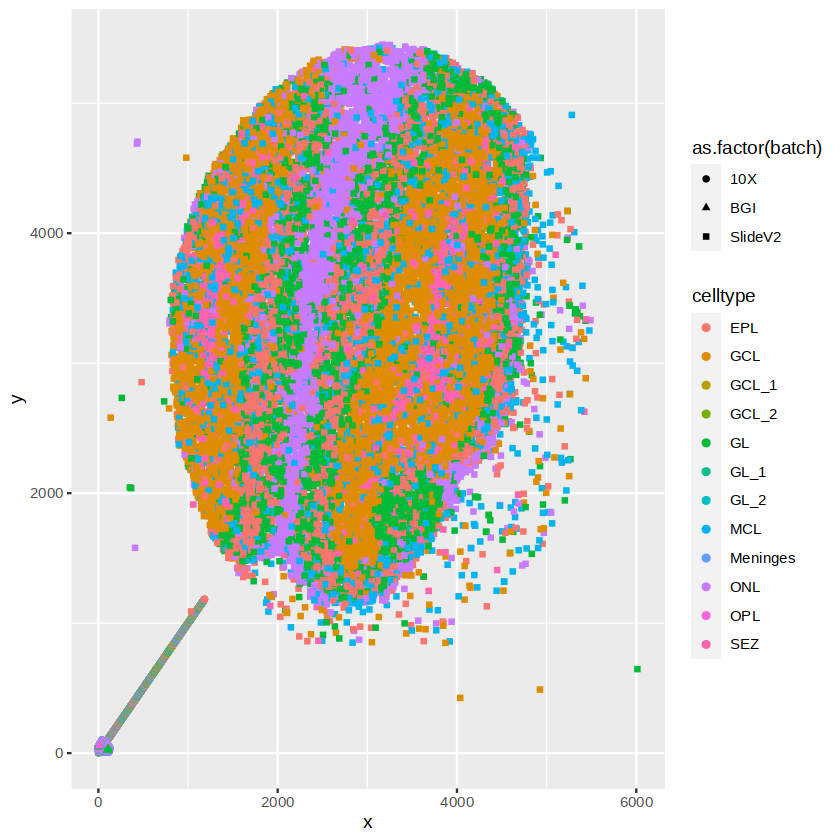

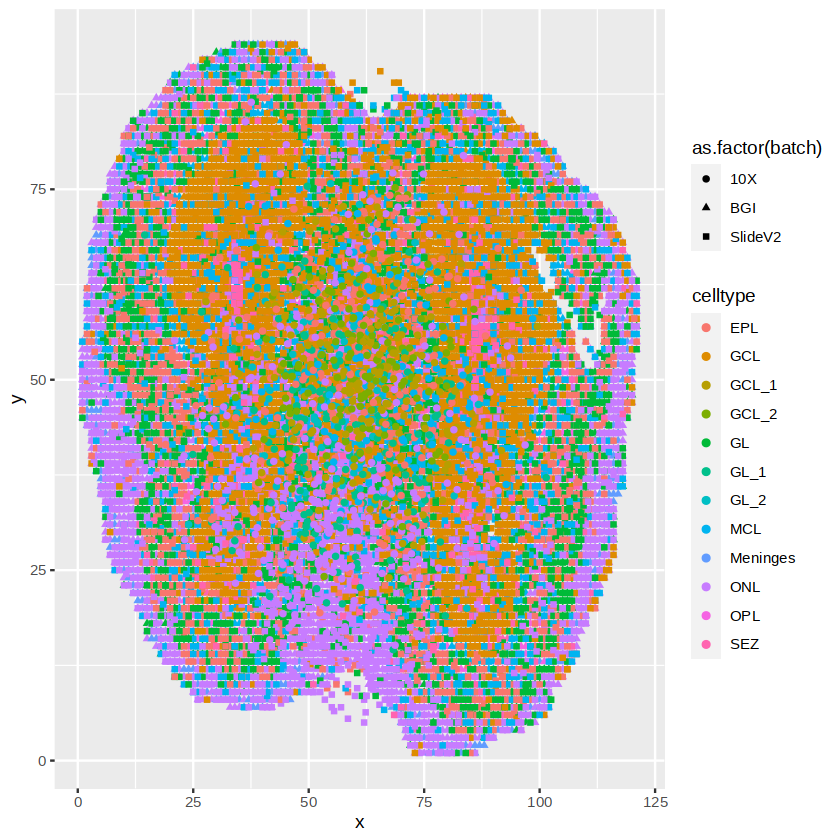

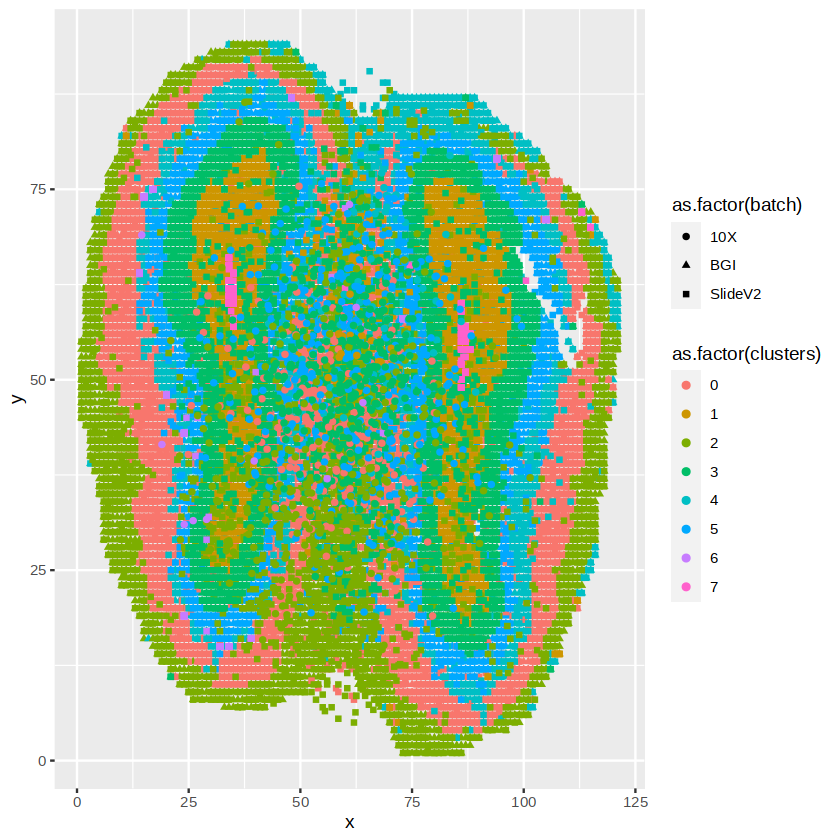

In [59]:
coord1=Coord[Coord$batch==ub[1],]
New_Coord=coord1
for(bb in 1:length(cc)){
    uc=cc[[bb]]
    coord2=Coord[Coord$batch==ub[bb+1],]
    for(clust in uc){
        coord1_=coord1[coord1$clusters==clust,]
        coord2_=coord2[coord2$clusters==clust,]
        embed1_=embed[rownames(coord1_),]
        embed2_=embed[rownames(coord2_),]
        pi=read.csv(paste(dirs,"gtt_output/coordinate_file/gwd_pi_",ub[1],"_",ub[bb+1],"_",clust,flags,".csv",sep=""),row.names=1,header=T)
#         x=t(vapply(colnames(pi),function(x){strsplit(x,'\\.')[[1]]},FUN.VALUE=c('1','2','3')))
#         colnames(pi)<-paste(x[,1],'-',x[,2],'-',x[,3],sep='')
#         x=t(vapply(colnames(pi),function(x){strsplit(x,'\\.')[[1]]},FUN.VALUE=c('1','2','3')))
#         colnames(pi)<-paste(x[,1],'-',x[,2],'.',x[,3],sep='')
#         a=data.frame(vapply(colnames(pi),function(x){strsplit(x,'X')[[1]][2]},FUN.VALUE='1'))[,1]
#         colnames(pi)<-vapply(a,function(x){x=strsplit(x,'\\.')[[1]];paste(x[1],x[2],x[3],sep='-')},FUN.VALUE='1')
        if(bb==1){
            x=t(vapply(colnames(pi),function(x){strsplit(x,'\\.')[[1]]},FUN.VALUE=c('1','2')))
            colnames(pi)<-paste(x[,1],'-',x[,2],sep='')
        }else{
            colnames(pi)<-data.frame(vapply(colnames(pi),function(x){substring(x,2)[[1]]},FUN.VALUE='2'))[,1]
            colnames(pi)<-vapply(colnames(pi),function(x){x=strsplit(x,'\\.')[[1]];paste(x[1],x[2],x[3],sep='-')},FUN.VALUE='1')
        }
        
#         if(bb==1){
#             x=t(vapply(colnames(pi),function(x){strsplit(x,'\\.')[[1]]},FUN.VALUE=c('1','2')))
#             colnames(pi)<-paste(x[,1],'-',x[,2],sep='')
#         }
        pi=pi[rownames(coord1_),rownames(coord2_)]
        if(length(dim(pi))==0){
            pi=as.matrix(pi,nrow=dim(coord1_)[1],ncol=dim(coord2_)[1])
            rownames(pi)<-rownames(coord1_)
            colnames(pi)<-rownames(coord2_)
        }
        new_coord2=coord2_
        idx=c()
        for(i in 1:dim(coord2_)[1]){
            idx=which(pi[,i]!=0)
            new_coord2[i,1:2]=colMeans(coord1_[idx,1:2])
        }
        New_Coord=rbind(New_Coord,new_coord2)
    }
}
ggplot(Coord,aes(x,y,color=celltype,shape=as.factor(batch)))+geom_point()
ggplot(New_Coord,aes(x,y,color=celltype,shape=as.factor(batch)))+geom_point()
ggplot(New_Coord,aes(x,y,color=as.factor(clusters),shape=as.factor(batch)))+geom_point()
# ggplot(New_Coord,aes(x,y,color=as.factor(clusters_STAGATE),shape=as.factor(batch)))+geom_point()
# ggplot(New_Coord,aes(x,y,color=as.factor(clusters_SEDR),shape=as.factor(batch)))+geom_point()
# ggplot(New_Coord,aes(x,y,color=as.factor(clusters_seurat),shape=as.factor(batch)))+geom_point()
# ggplot(New_Coord,aes(x,y,color=as.factor(clusters_harmony),shape=as.factor(batch)))+geom_point()
write.csv(New_Coord,paste(dirs,"gtt_output/coordinate_file/gtt_new_coordinate",flags,'_',clust_cate,exp,".csv",sep=""))

In [68]:
uc=cc[[bb]]
coord2=Coord[Coord$batch==ub[bb+1],]
clust=uc[1]
coord1_=coord1[coord1$clusters==clust,]
coord2_=coord2[coord2$clusters==clust,]
embed1_=embed[rownames(coord1_),]
embed2_=embed[rownames(coord2_),]
pi=read.csv(paste(dirs,"gtt_output/coordinate_file/gwd_pi_",ub[1],"_",ub[bb+1],"_",clust,flags,".csv",sep=""),row.names=1,header=T)
if(bb==1){
    x=t(vapply(colnames(pi),function(x){strsplit(x,'\\.')[[1]]},FUN.VALUE=c('1','2')))
    colnames(pi)<-paste(x[,1],'-',x[,2],sep='')
}else{
    colnames(pi)<-data.frame(vapply(colnames(pi),function(x){substring(x,2)[[1]]},FUN.VALUE='2'))[,1]
    colnames(pi)<-vapply(colnames(pi),function(x){x=strsplit(x,'\\.')[[1]];paste(x[1],x[2],x[3],sep='-')},FUN.VALUE='1')
}
pi=pi[rownames(coord1_),rownames(coord2_)]
new_coord2=coord2_
for(i in 1:dim(coord2_)[1]){
    idx=which(pi[,i]!=0)
    new_coord2[i,1:2]=colMeans(coord1_[idx,1:2])
}


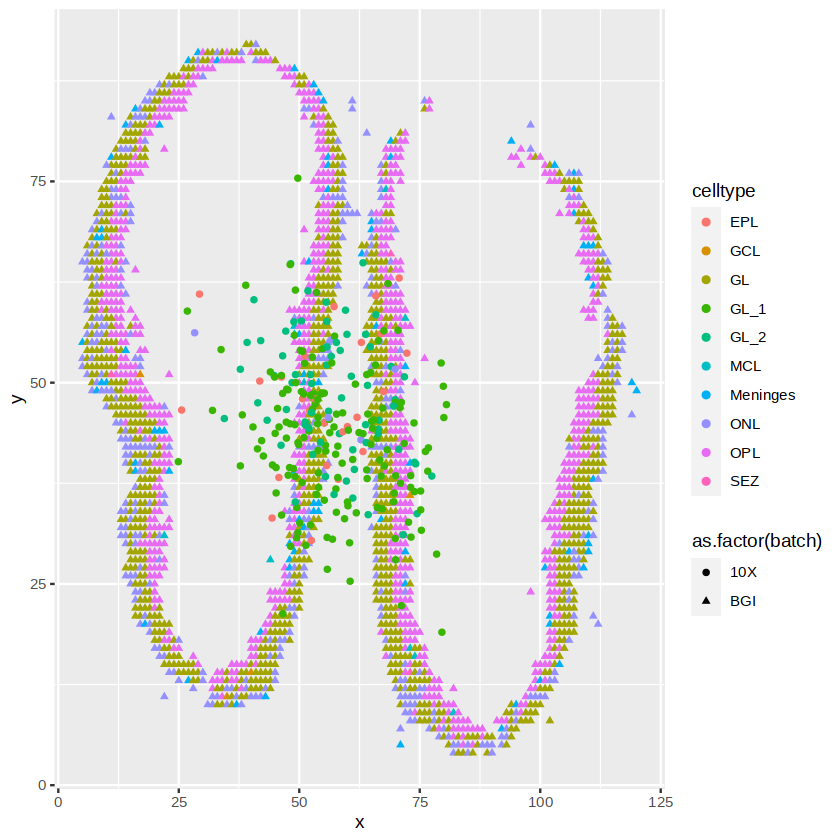

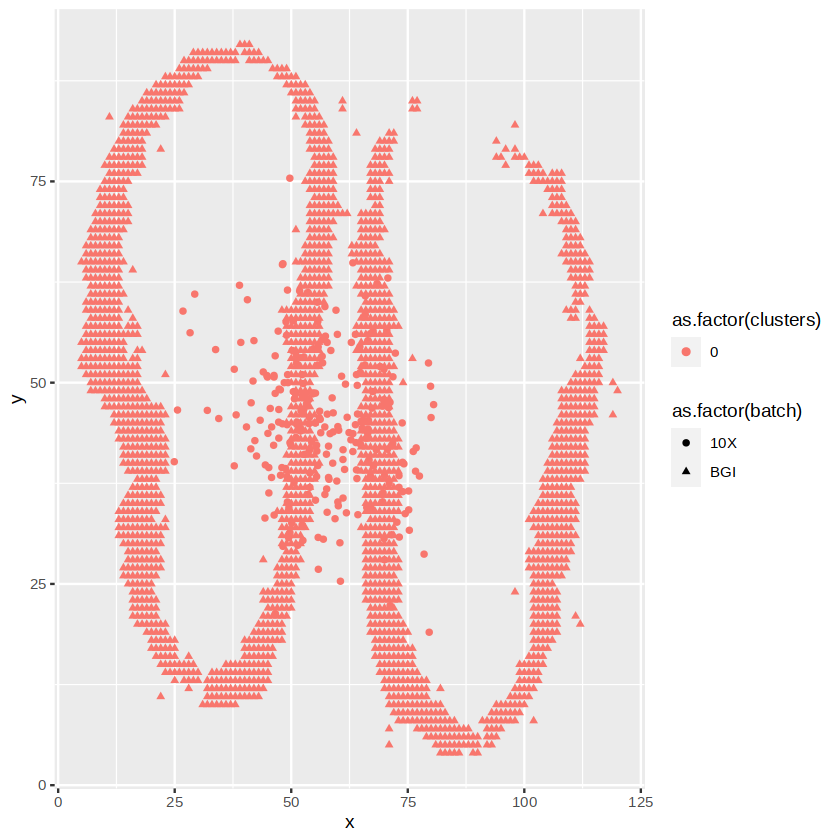

In [73]:
a=rbind(coord1_,new_coord2)
ggplot(a,aes(x,y,color=celltype,shape=as.factor(batch)))+geom_point()
ggplot(a,aes(x,y,color=as.factor(clusters),shape=as.factor(batch)))+geom_point()

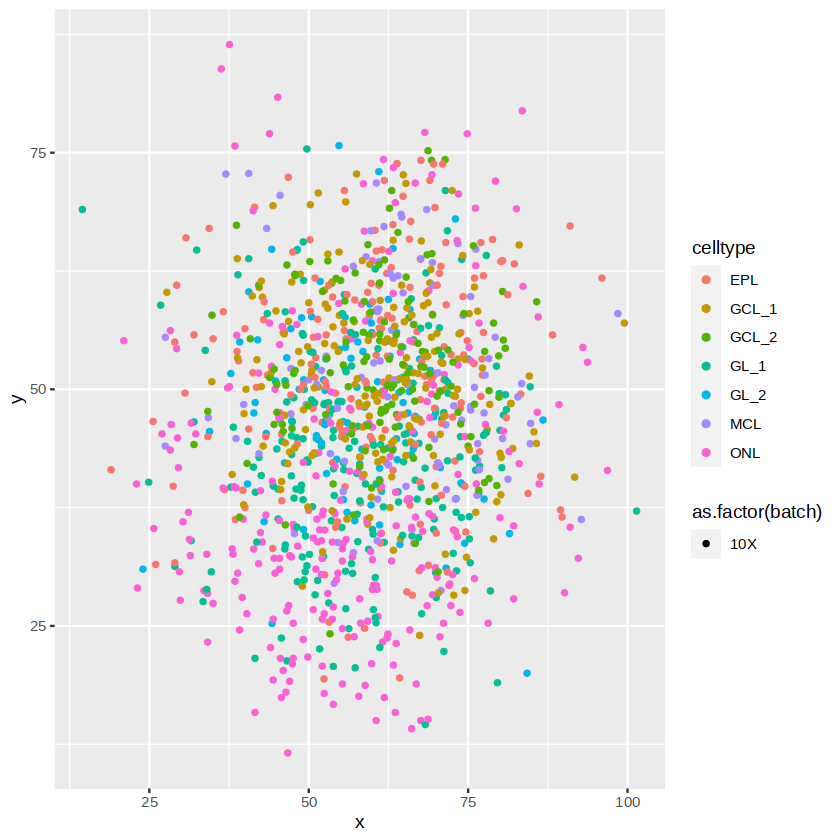

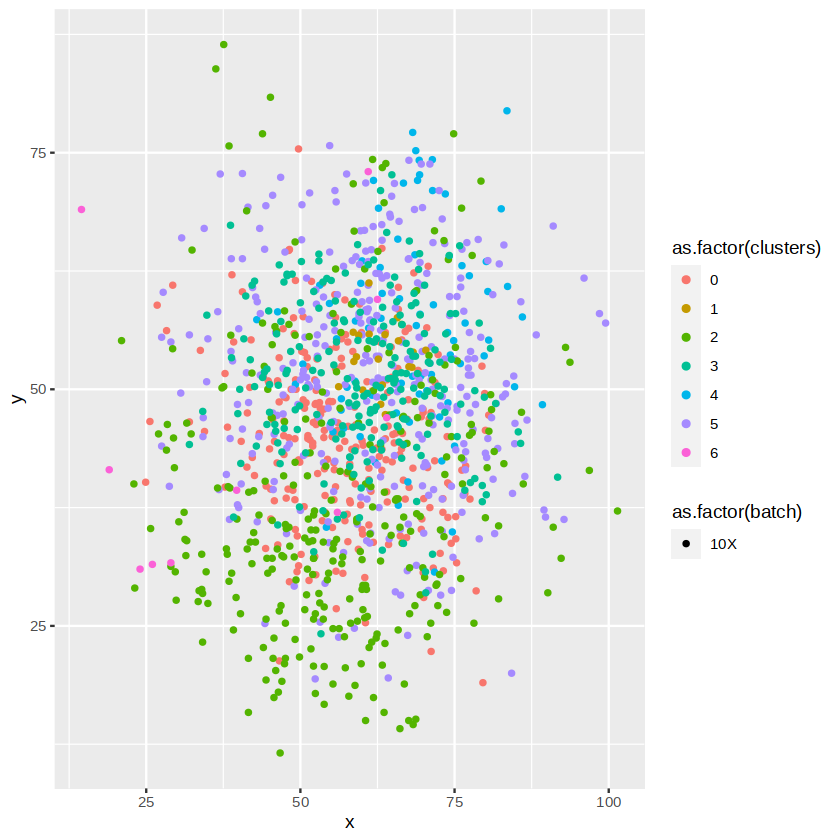

In [60]:
New_Coord1=New_Coord[New_Coord$batch=='10X',]
ggplot(New_Coord1,aes(x,y,color=celltype,shape=as.factor(batch)))+geom_point()
ggplot(New_Coord1,aes(x,y,color=as.factor(clusters),shape=as.factor(batch)))+geom_point()

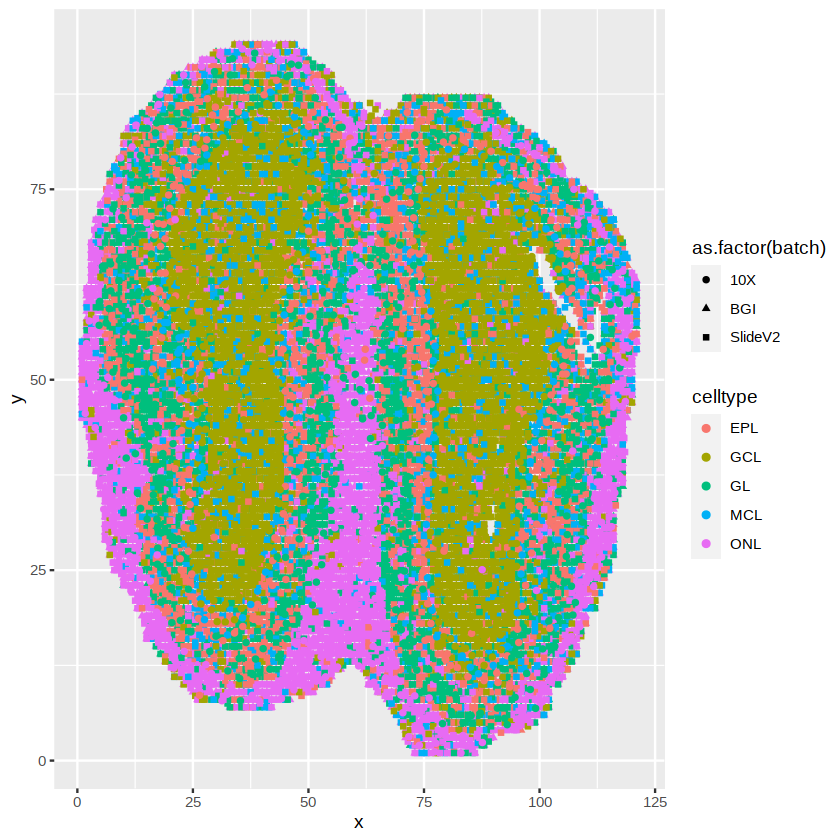

In [86]:
New_Coord$celltype[New_Coord$celltype=='SEZ']='GCL'
New_Coord$celltype[New_Coord$celltype=='Meninges']='ONL'
New_Coord$celltype[New_Coord$celltype=='OPL']='EPL'
New_Coord$celltype[New_Coord$celltype=='GCL_1']='GCL'
New_Coord$celltype[New_Coord$celltype=='GCL_2']='GCL'
New_Coord$celltype[New_Coord$celltype=='GL_1']='GL'
New_Coord$celltype[New_Coord$celltype=='GL_2']='GL'
ggplot(New_Coord,aes(x,y,color=celltype,shape=as.factor(batch)))+geom_point()

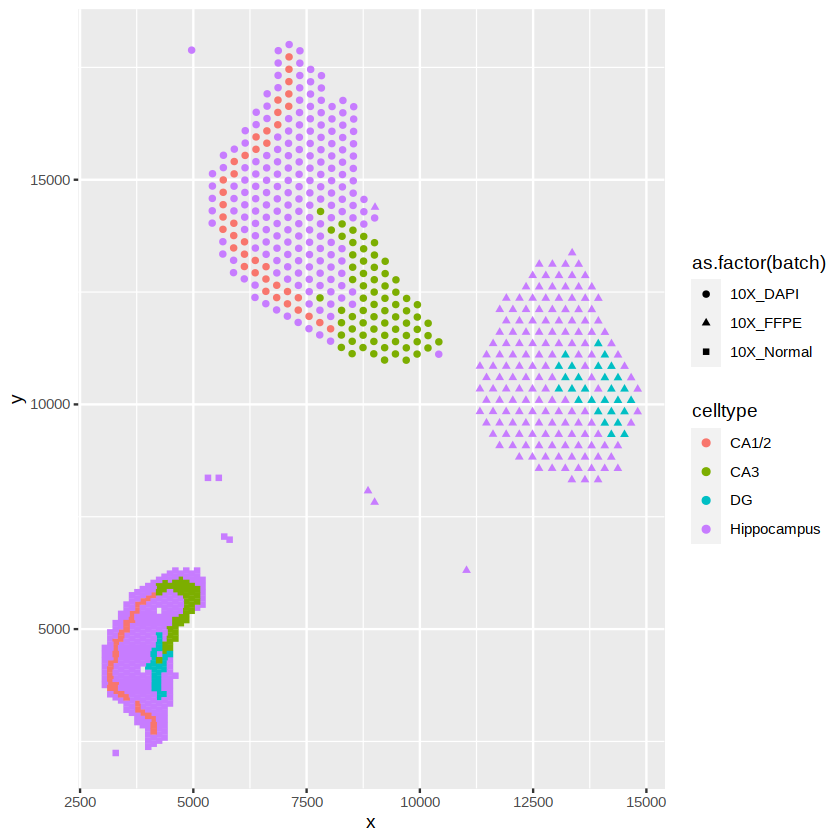

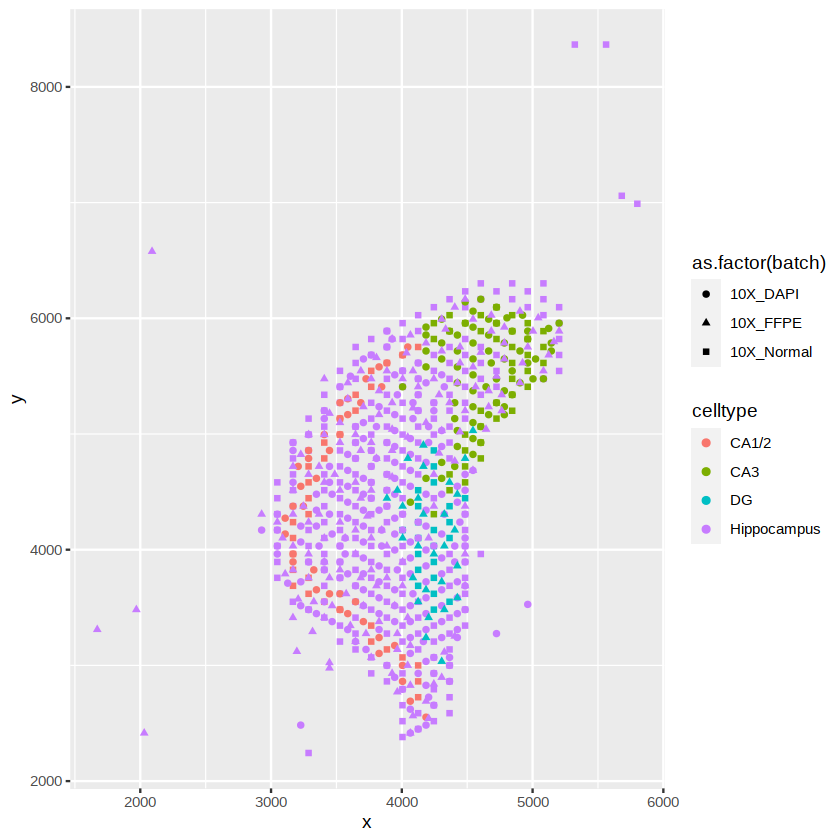

In [7]:
a=Coord[Coord$celltype%in%c('CA1/2','CA3','DG','Hippocampus'),]
b=New_Coord[New_Coord$celltype%in%c('CA1/2','CA3','DG','Hippocampus'),]
ggplot(a,aes(x,y,color=celltype,shape=as.factor(batch)))+geom_point()
ggplot(b,aes(x,y,color=celltype,shape=as.factor(batch)))+geom_point()

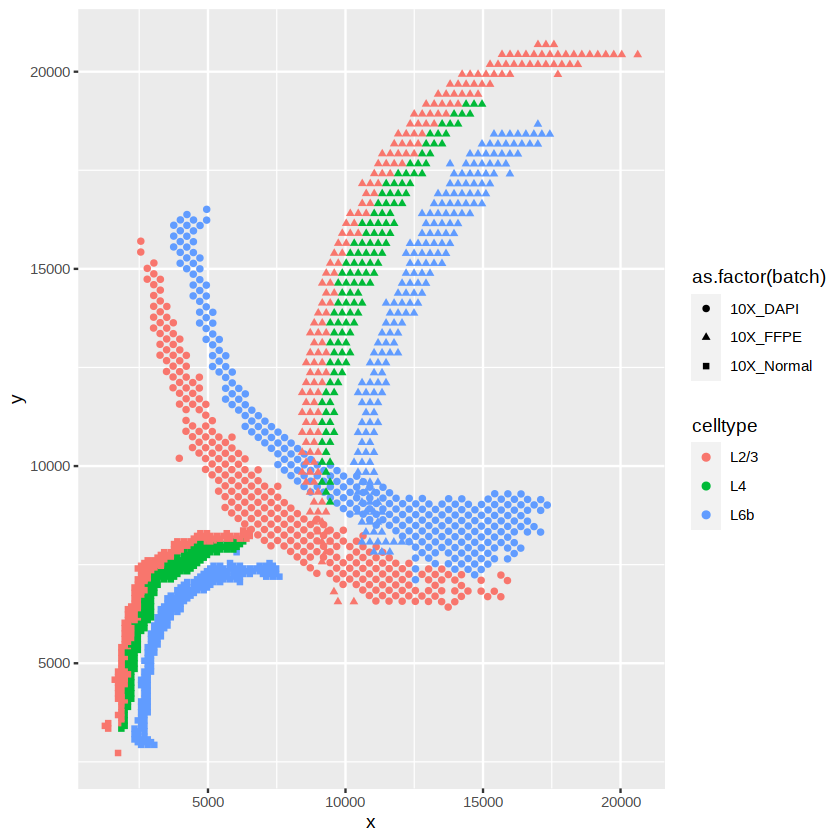

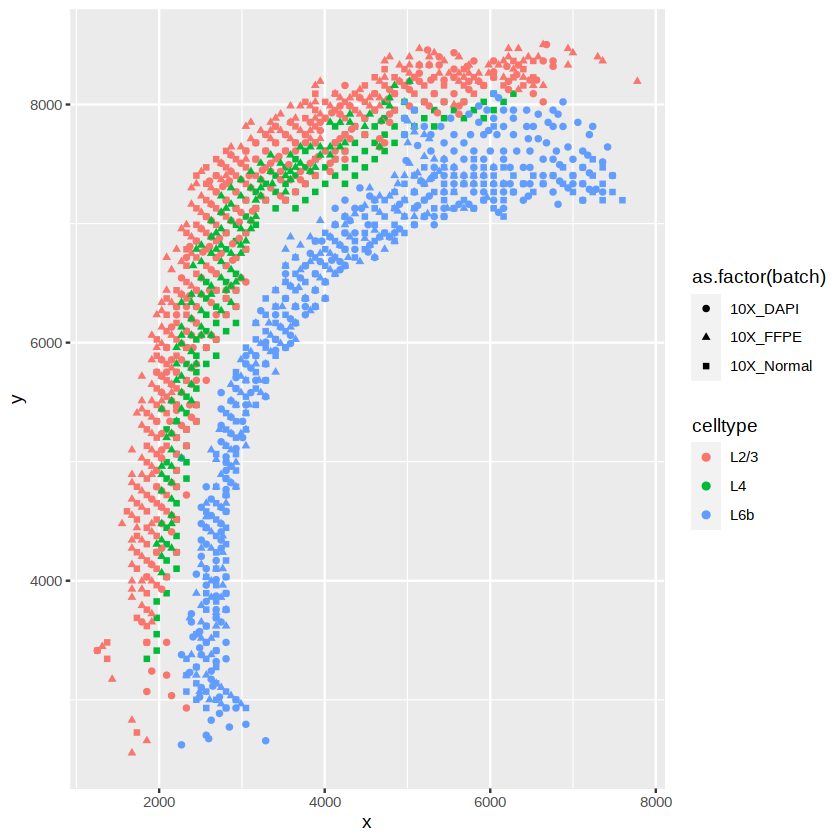

In [9]:
a=Coord[Coord$celltype%in%c('L2','L2/3','L6b','L5','L4'),]
b=New_Coord[New_Coord$celltype%in%c('L2','L2/3','L6b','L5','L4'),]
ggplot(a,aes(x,y,color=celltype,shape=as.factor(batch)))+geom_point()
ggplot(b,aes(x,y,color=celltype,shape=as.factor(batch)))+geom_point()

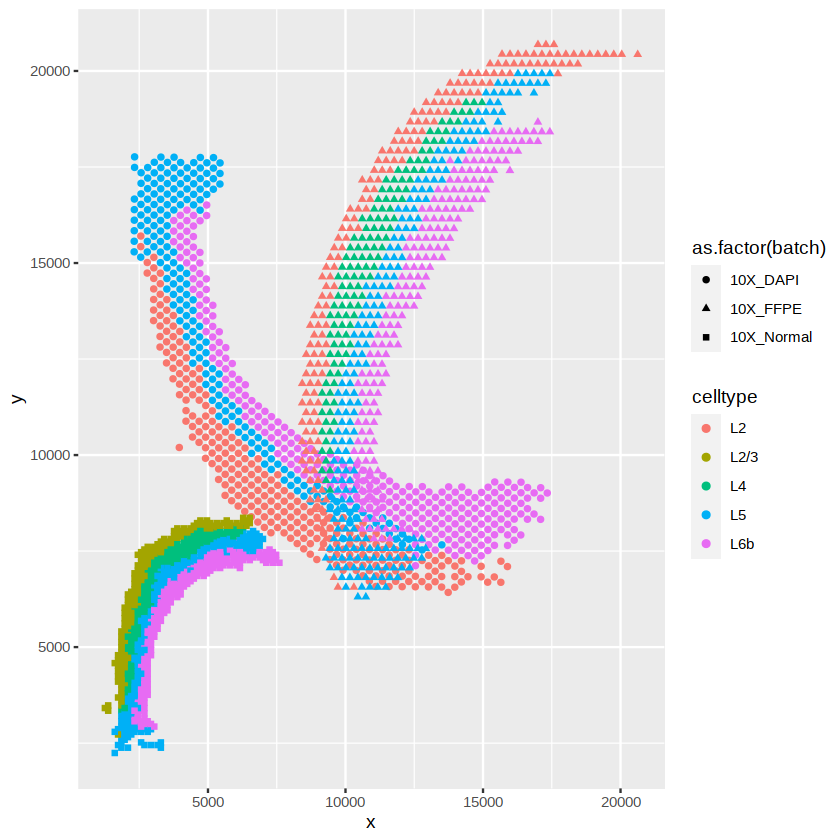

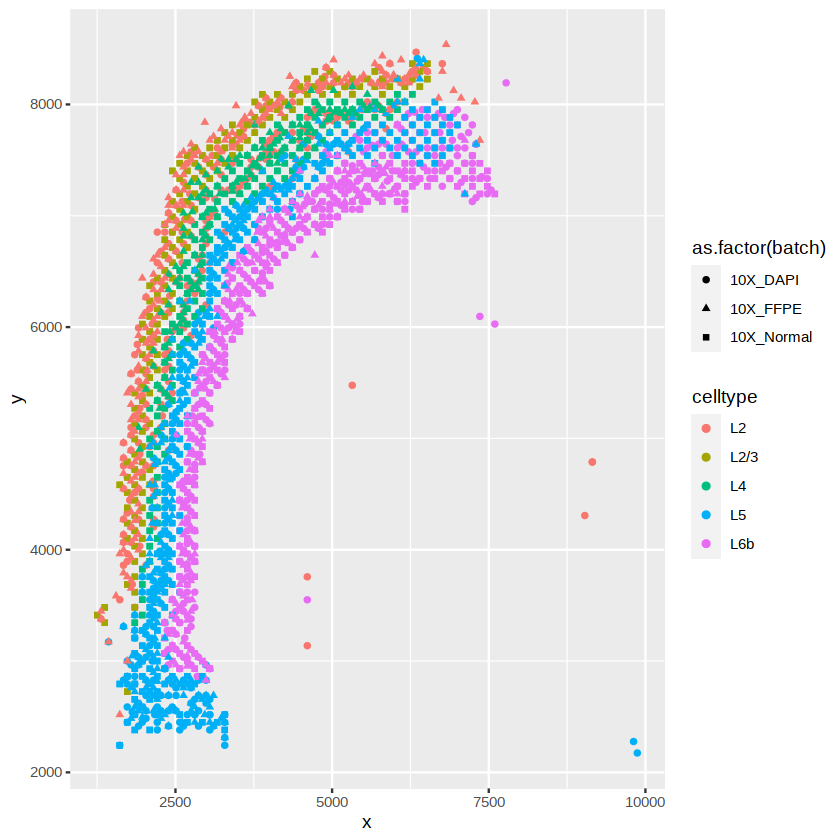

In [50]:
a=Coord[Coord$celltype%in%c('L2','L2/3','L6b','L5','L4'),]
b=New_Coord1[New_Coord1$celltype%in%c('L2','L2/3','L6b','L5','L4'),]
ggplot(a,aes(x,y,color=celltype,shape=as.factor(batch)))+geom_point()
ggplot(b,aes(x,y,color=celltype,shape=as.factor(batch)))+geom_point()

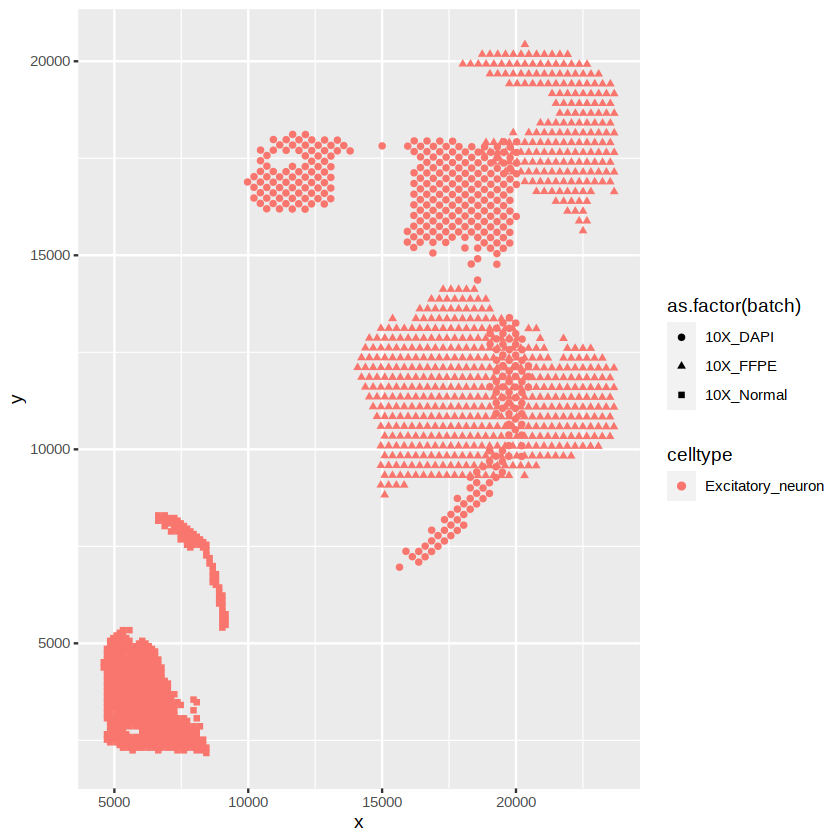

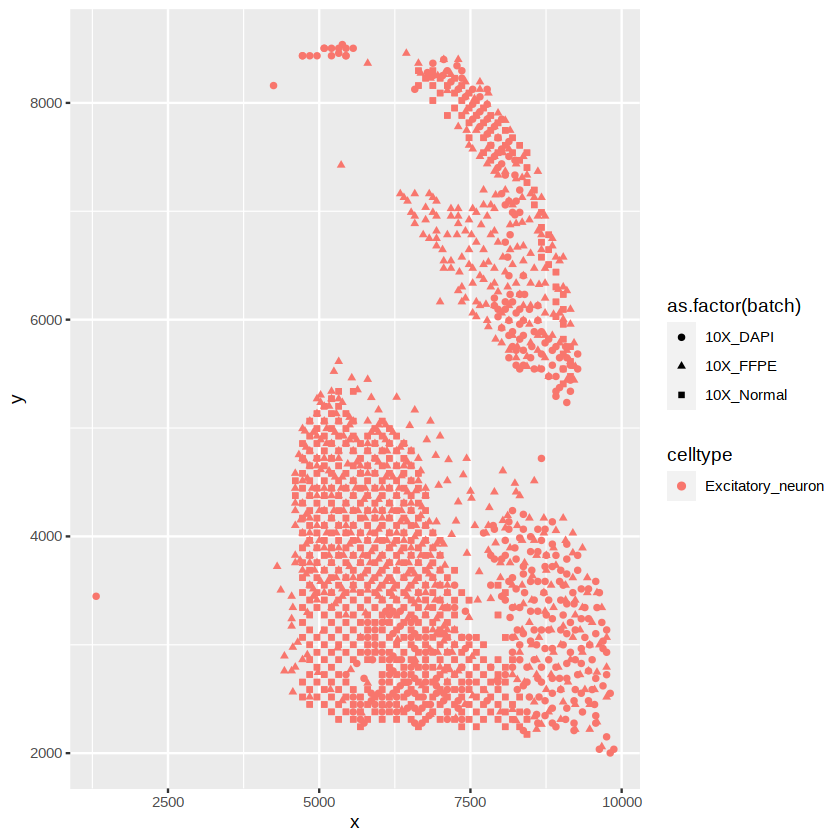

In [51]:
a=Coord[Coord$celltype%in%c('Excitatory_neuron'),]
b=New_Coord1[New_Coord1$celltype%in%c('Excitatory_neuron'),]
ggplot(a,aes(x,y,color=celltype,shape=as.factor(batch)))+geom_point()
ggplot(b,aes(x,y,color=celltype,shape=as.factor(batch)))+geom_point()

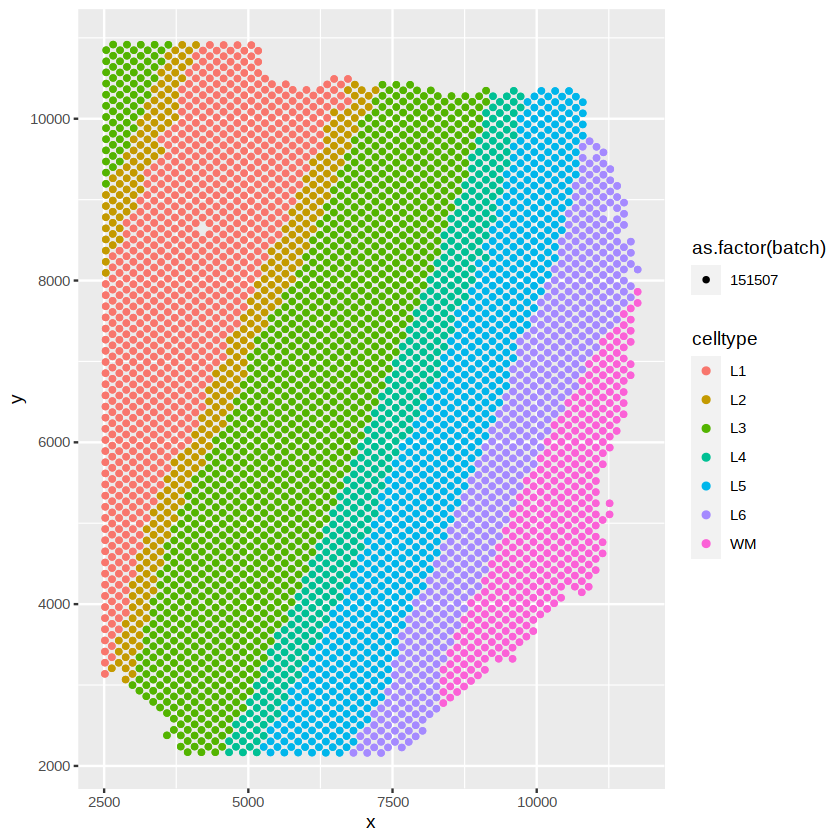

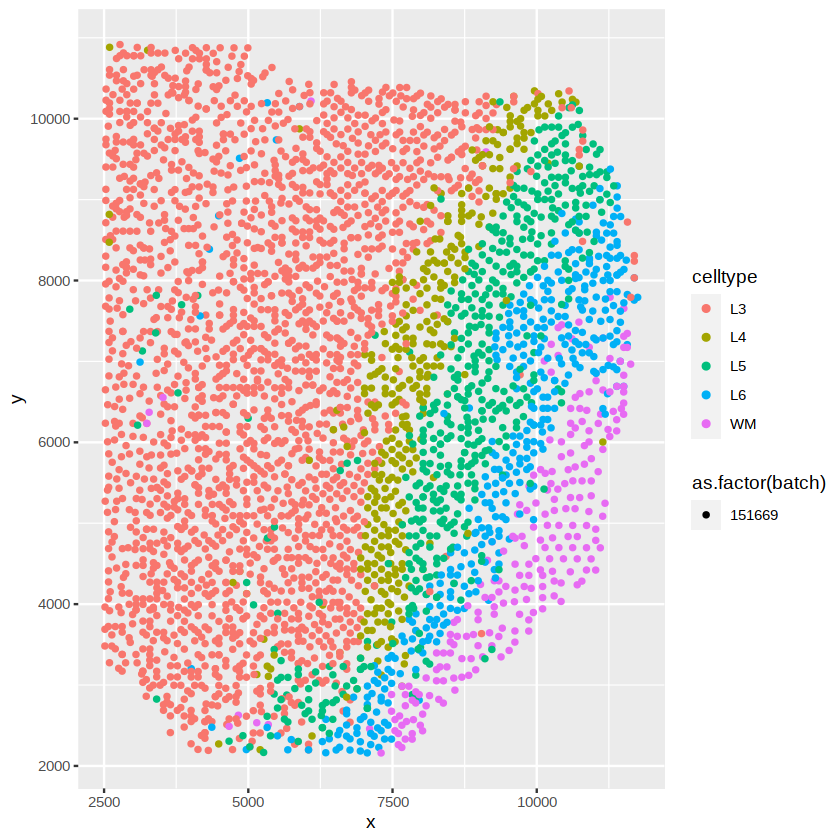

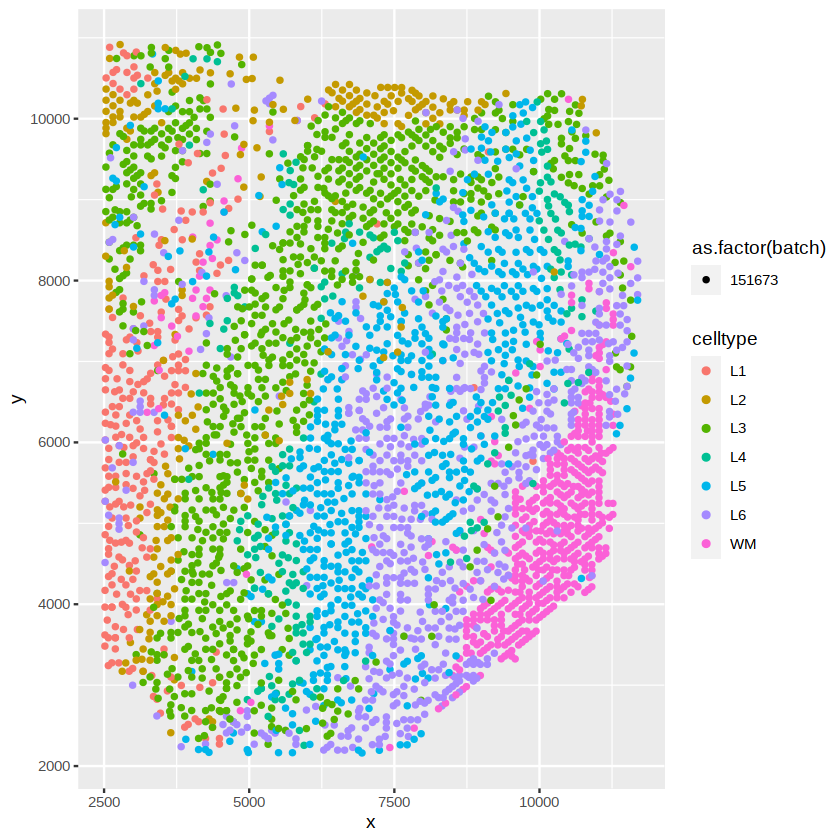

In [14]:
a=New_Coord[New_Coord$batch==ub[1],]
ggplot(a,aes(x,y,color=celltype,shape=as.factor(batch)))+geom_point()
a=New_Coord[New_Coord$batch==ub[2],]
ggplot(a,aes(x,y,color=celltype,shape=as.factor(batch)))+geom_point()
a=New_Coord[New_Coord$batch==ub[3],]
ggplot(a,aes(x,y,color=celltype,shape=as.factor(batch)))+geom_point()

线性变换

In [17]:
New_Coord_Specific=data.frame(x=0,y=0,clusters=0,batch=0,celltype=0)
i=3
new=New_Coord[New_Coord$batch==ub[i],]
old=Coord[rownames(new),]
uc=setdiff(unique(Coord$clusters[Coord$batch==ub[i]]),cc[[i-1]])
PROCRUSTES=procrustes(as.matrix(new[,1:2]),as.matrix(old[,1:2]))
x1=Coord[Coord$clusters%in%uc,]

In [15]:
predict(PROCRUSTES,as.matrix(x1[,1:2]))

[,1]      [,2]    
Cell511 2.4848223 1.638414
Cell520 2.3701511 1.768254
Cell522 2.0551037 4.274371
Cell523 1.8209477 2.705295
Cell530 1.0775269 1.184386
Cell531 1.6737650 3.843667
Cell541 1.7692540 3.313735
Cell544 1.2917710 3.168933
Cell551 1.0215775 1.756769
Cell552 1.1094016 3.692394
Cell565 2.3045900 4.545228
Cell569 1.5081885 1.176119
Cell576 0.7728403 4.336156
Cell584 1.3813456 2.631517
Cell586 2.4756649 2.578276
Cell587 1.1641204 1.101074
Cell595 1.2094529 1.615238
Cell601 1.0367816 1.988343
Cell606 0.9968608 1.892331
Cell608 1.2461556 4.396777
Cell610 2.3613048 2.030283
Cell611 2.1720390 2.961265
Cell613 2.0412484 1.744882
Cell616 1.1833869 1.436182
Cell617 1.2352077 3.696064
Cell625 1.9557274 1.541031
Cell629 1.6574980 2.219984
Cell637 1.1755745 1.471484
Cell639 2.2587996 4.671300
Cell640 1.0986634 2.259763
⋮       ⋮         ⋮       
Cell831 2.3984807 3.371398
Cell835 2.4827769 4.017308
Cell838 2.4353388 3.802374
Cell865 1.3444386 3.867434
Cell867 2.2819502 2.137155
Cell869 2.0071269 2.383314
Cell874 0.9556128 1.460827
Cell882 2.2502462 4.710123
Cell894 1.4169202 3.742933
Cell895 2.1802613 3.237397
Cell896 0.8043975 3.990065
Cell907 1.7388503 3.952444
Cell908 1.6874034 1.369241
Cell910 1.4360578 3.204179
Cell911 2.0736485 2.299682
Cell914 1.6301129 4.273031
Cell923 1.8097014 3.290855
Cell924 2.5450994 2.554680
Cell926 1.9006675 4.076280
Cell939 1.5304086 3.668168
Cell947 1.3575448 1.784639
Cell950 1.1424620 3.720478
Cell953 1.0511604 1.697360
Cell961 0.9899559 4.288859
Cell968 1.4225522 3.130840
Cell970 1.6635125 3.764854
Cell975 1.1980458 3.616167
Cell978 1.0376384 3.570574
Cell986 2.3482201 3.819459
Cell998 2.2973927 1.893833

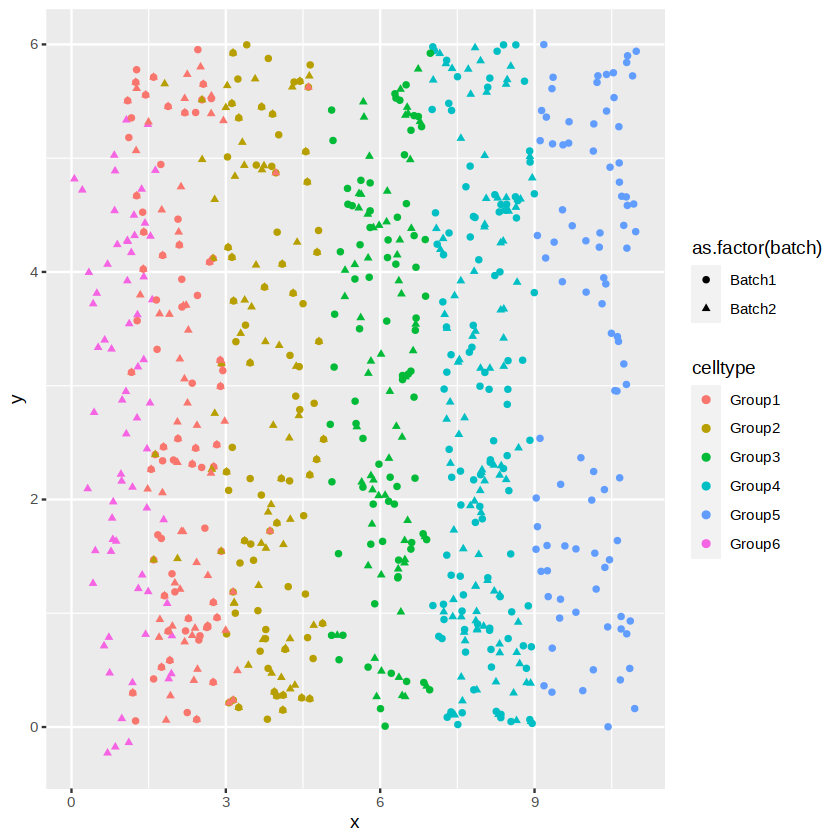

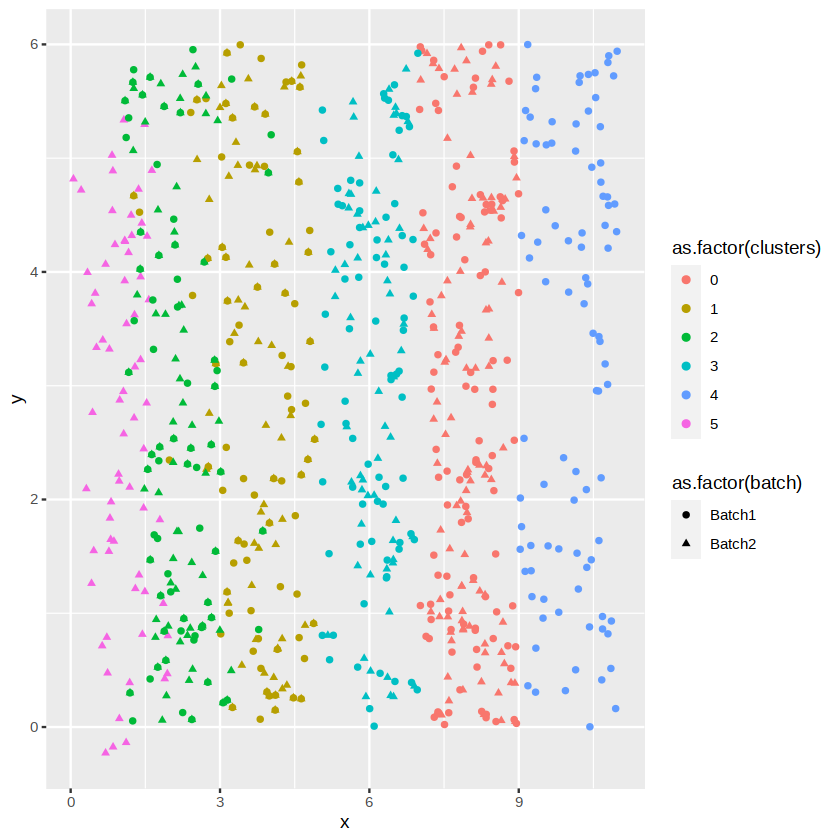

In [22]:
New_Coord_Specific=data.frame(x=0,y=0,clusters=0,batch=0,celltype=0)
for(i in 2:length(ub)){
    new=New_Coord[New_Coord$batch==ub[i],]
    old=Coord[rownames(new),]
    a1=data.frame(apply(new[,1:2],2,sd))
    a2=data.frame(apply(old[,1:2],2,sd))
    uc=setdiff(unique(Coord$clusters[Coord$batch==ub[i]]),cc[[i-1]])
    if(length(uc)>0){
#         PROCRUSTES=procrustes(as.matrix(new[,1:2]),as.matrix(old[,1:2]),scale=FALSE)
        PROCRUSTES=procrustes(as.matrix(new[,1:2]),as.matrix(old[,1:2]))
        x1=Coord[Coord$clusters%in%uc,]
        x1[,1:2]=predict(PROCRUSTES, as.matrix(x1[,1:2]))
    #     x1[,1]=x1[,1]*(a1[1,1]/a2[1,1])
    #     x1[,2]=x1[,2]*(a1[2,1]/a2[2,1])
        New_Coord_Specific<-rbind(New_Coord_Specific,x1)
    }
}
New_Coord_Specific=New_Coord_Specific[-1,]
New_Coord_All=rbind(New_Coord_Specific,New_Coord)

ggplot(New_Coord_All,aes(x,y,color=celltype,shape=as.factor(batch)))+geom_point()
ggplot(New_Coord_All,aes(x,y,color=as.factor(clusters),shape=as.factor(batch)))+geom_point()
# write.csv(New_Coord_All,paste(dirs,"gtt_output/coordinate_file/gtt_new_coordinate",flags,'_',clust_cate,".csv",sep=""))

In [17]:
dim(New_Coord_All)
dim(Coord)
dim(New_Coord)

[1] 846   5

[1] 846   5

[1] 596   5

knn method

Warning message:
“Removed 846 rows containing missing values (geom_point).”


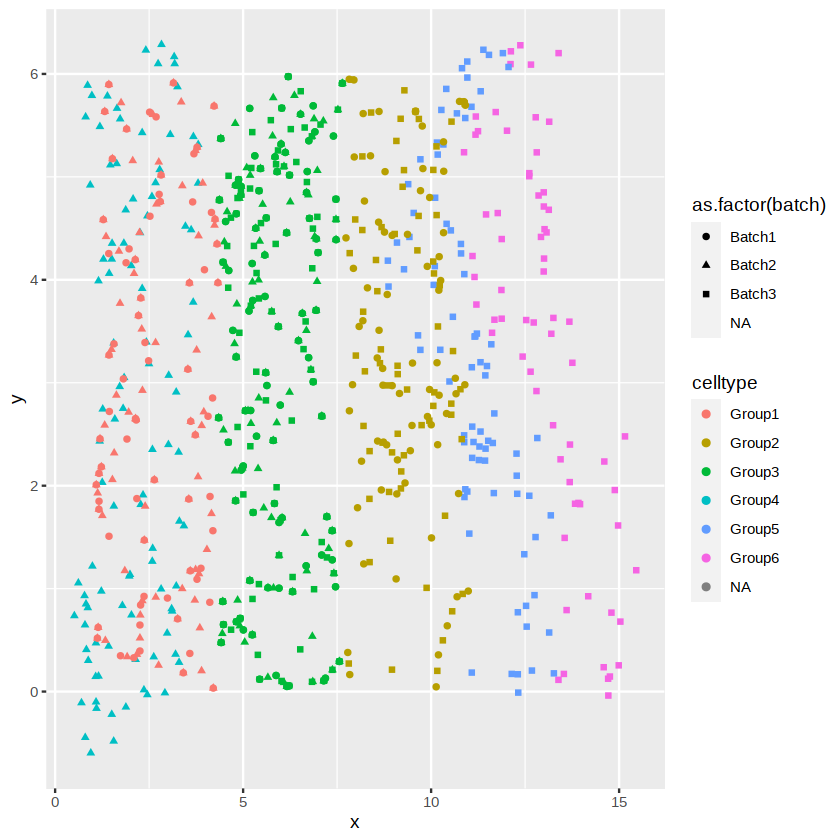

In [10]:
knn=10
######求scale######
New_Coord_Specific=data.frame(x=0,y=0,clusters=0,batch=0,celltype=0)
for(i in 2:length(ub)){
    new=New_Coord[New_Coord$batch==ub[i],]
    old=Coord[rownames(new),]
    scale=median(dist(new[1:2])/dist(old[rownames(new),1:2]))
    uc=setdiff(unique(Coord$clusters[Coord$batch==ub[i]]),cc[[i-1]])
    
    for(j in 1:length(uc)){
        na=rownames(Coord)[Coord$clusters==uc[j]]
        ind=get.knnx(data=old[,1:2],query=Coord[na,1:2],knn)$nn.index
        for(k in 1:dim(ind)[1]){
            x=Coord[na[k],]
            oo=old[ind[k,],]
            nn=new[ind[k,],]
            dx=(oo[,'x']-x[,'x'])*scale
            dy=(oo[,'y']-x[,'y'])*scale
            nnx=median(nn[,'x']-dx)
            nny=median(nn[,'y']-dy)
            nn=data.frame(x=nnx,y=nny,clusters=x$clusters,batch=x$batch,celltype=x$celltype)
            rownames(nn)<-rownames(x)
            New_Coord_Specific<-rbind(New_Coord_Specific,nn)
        }
    }
}
New_Coord_Specific=New_Coord_Specific[-1,]
new=New_Coord[New_Coord$batch==ub[i],]
aa=c()
for(i in 1:length(cc)){
    aa<-union(aa,cc[[i]])
}
uc=setdiff(unique(Coord$clusters[Coord$batch==ub[1]]),aa)
for(i in 1:length(uc)){
    New_Coord_Specific=rbind(New_Coord_Specific,Coord[Coord[,'clusters']==uc[i],])
}
New_Coord_All=rbind(New_Coord_Specific,New_Coord)
ggplot(New_Coord_All,aes(x,y,color=celltype,shape=as.factor(batch)))+geom_point()
write.csv(New_Coord_All,paste(dirs,"gtt_output/coordinate_file/gtt_new_coordinate",batch_sim,types,".csv",sep=""))

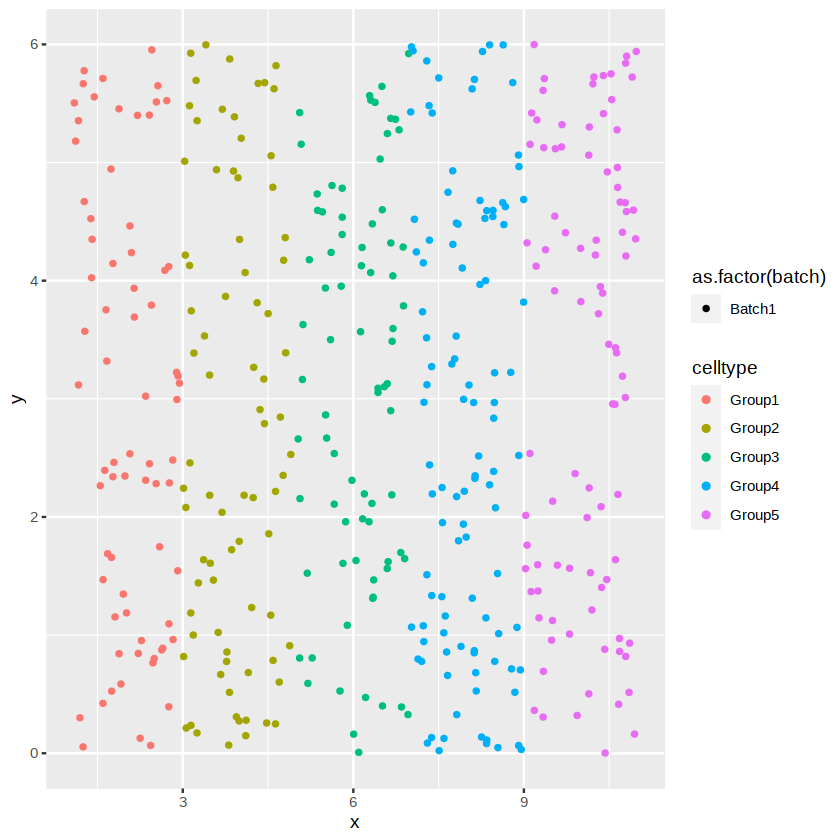

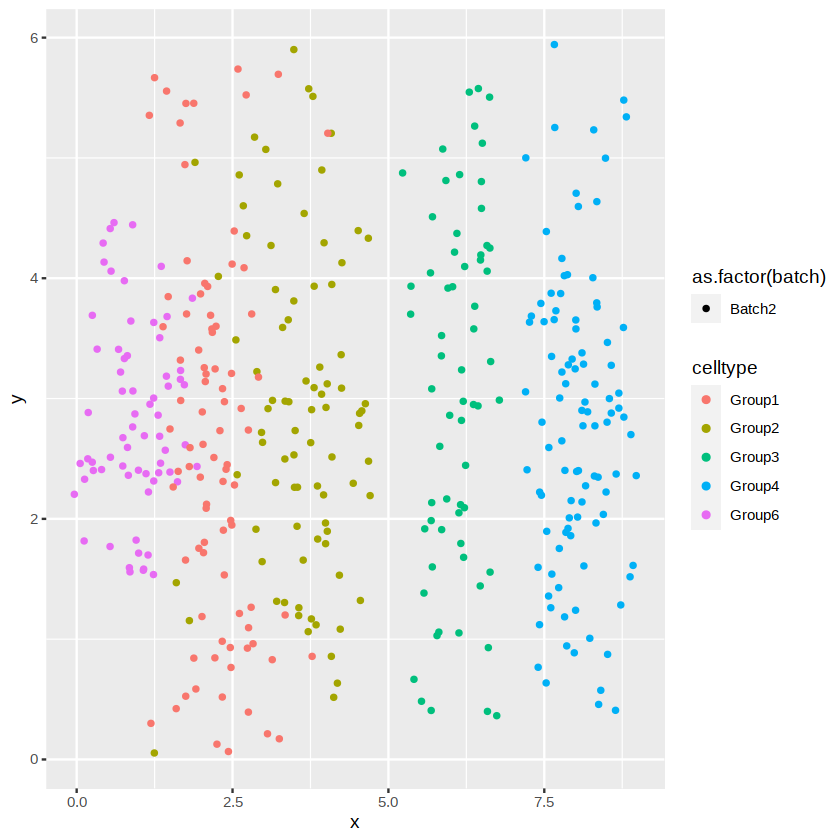

In [181]:
a=New_Coord_All[New_Coord_All$batch==ub[1],]
ggplot(a,aes(x,y,color=celltype,shape=as.factor(batch)))+geom_point()
a=New_Coord_All[New_Coord_All$batch==ub[2],]
ggplot(a,aes(x,y,color=celltype,shape=as.factor(batch)))+geom_point()


useless

Warning message in merge.data.frame(Coord3, meta, by = "row.names"):
“column name ‘Row.names’ is duplicated in the result”


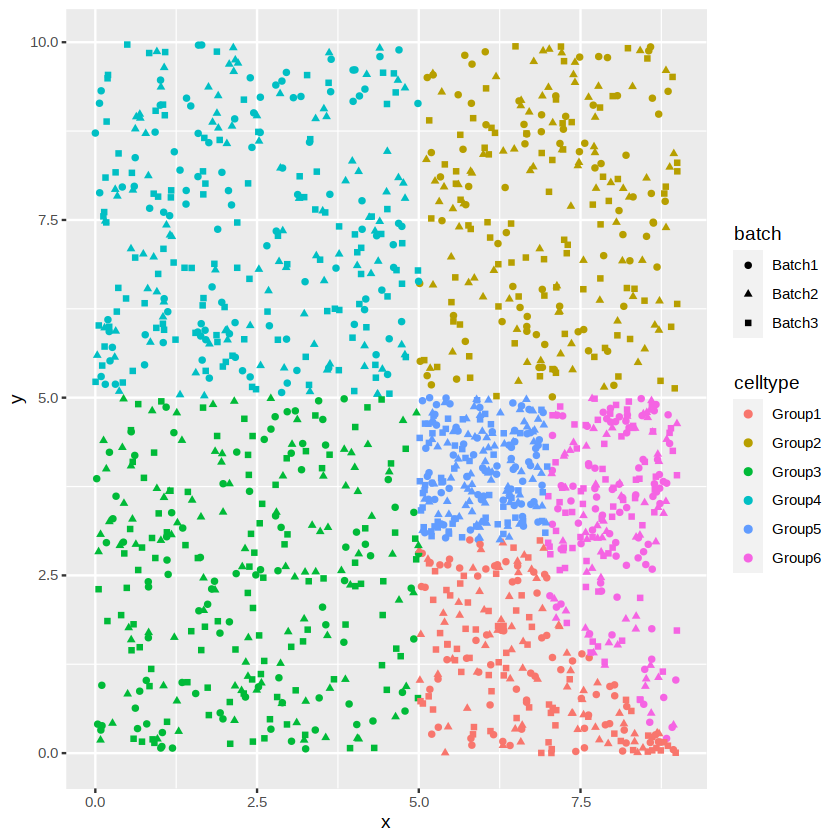

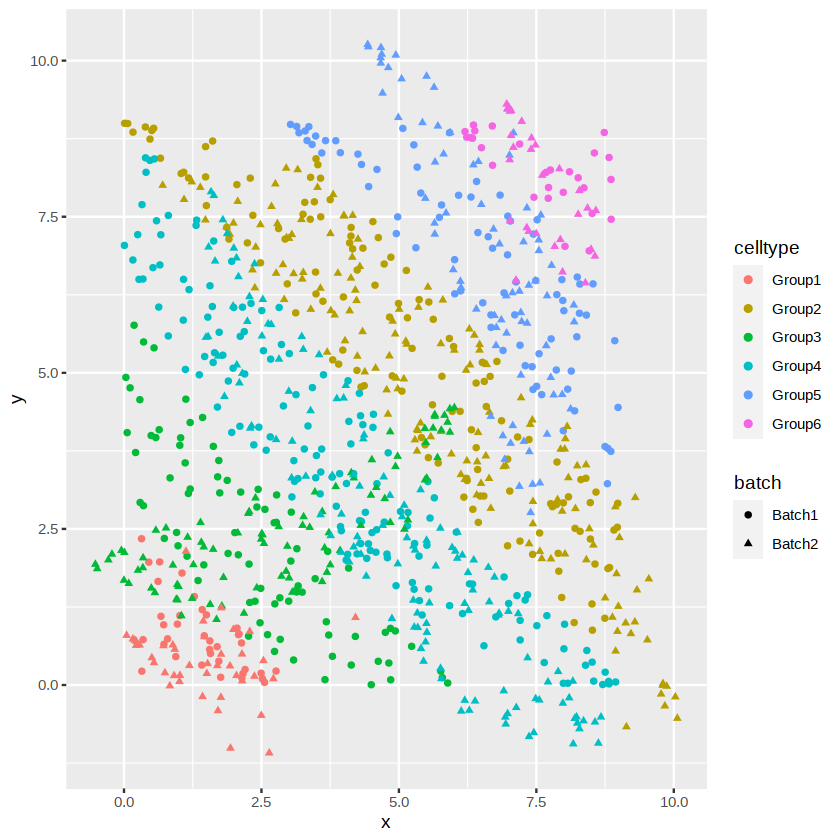

In [46]:
KNN=1
Coord1=read.csv(paste(dirs,"gtt_input/coord1",batch_sim,types,".csv",sep=""),header=T,row.names=1,sep=',')
Coord2=read.csv(paste(dirs,"gtt_input/coord2",batch_sim,types,".csv",sep=""),header=T,row.names=1,sep=',')
# Coord3=read.csv(paste(dirs,"gtt_input/coord3",batch_sim,types,".csv",sep=""),header=T,row.names=1,sep=',')
if(dim(Coord1)[2]>2){
    Coord1<-Coord1[,1:2]
    Coord2<-Coord2[,1:2]
#     Coord3<-Coord3[,1:2]
}
Coord1<-merge(Coord1,meta,by='row.names')
rownames(Coord1)<-Coord1[,1]
Coord1<-Coord1[,-1]
Coord2<-merge(Coord2,meta,by='row.names')
rownames(Coord2)<-Coord2[,1]
Coord2<-Coord2[,-1]
Coord3<-merge(Coord3,meta,by='row.names')
rownames(Coord3)<-Coord3[,1]
# Coord3<-Coord3[,-1]
# Coord<-rbind(Coord1,Coord2,Coord3)
ggplot(Coord,aes(x,y,color=celltype,shape=batch))+geom_point()
######calculate pi for each clusters#######
ub=unique(meta[,2])
new_coord1=data.frame(x=0,y=0,celltype=0,batch=0)
new_coord2=data.frame(x=0,y=0,celltype=0,batch=0)
for(ub_id in 2:length(ub)){
    uc=intersect(clusters$clusters[clusters[,2]==ub[1]],clusters$clusters[clusters[,2]==ub[ub_id]])
    
    for(clust in uc){
        na=rownames(clusters)[clusters==clust]
        a=embed[na,]
        embed1=a[meta[na,2]==ub[1],3:dim(embed)[2]]
        embed2=a[meta[na,2]==ub[ub_id],3:dim(embed)[2]]
        gtt_dist=dist2(embed1,embed2)
        gtt_pi=1/gtt_dist
        coord1=Coord1[rownames(gtt_dist),]
        coord2=Coord2[colnames(gtt_dist),]
        ####translation and scale######
        trans=colMeans(coord1[,1:2])-colMeans(coord2[,1:2])
        scale=apply(X=coord1[,1:2], MARGIN=2, FUN=sd)/apply(X=coord2[,1:2], MARGIN=2, FUN=sd)
        coord2[,1:2]=t(t(coord2[,1:2])+trans)
        coord2[,1:2]=t(t(coord2[,1:2])*scale)
        coord21=coord2
        #########procrus analysis#########
        ###find anchors: by means of knn####
#         a=get.knnx(as.matrix(embed1),as.matrix(embed2),k=KNN)
#         knn21=a$nn.index
#         coord21=coord2
#         for(i in 1:dim(knn21)[1]){
#             coord21[i,1:2]=t(colMeans(coord1[knn21[i,],1:2]))
#         }
#         PROCRUSTES=procrustes(coord21[,1:2],coord2[,1:2],scale=FALSE)
#         coord21[,1:2]=fitted(PROCRUSTES)[,1:2]
         ###find anchors: by MNN####
        a=get.knnx(as.matrix(embed2),as.matrix(embed1),k=KNN)
        knn12=a$nn.index
        a=get.knnx(as.matrix(embed1),as.matrix(embed2),k=KNN)
        knn21=a$nn.index
        a=which((knn21[knn12[,1],1]-seq(1,dim(embed1)[1]))==0)
        coord1_=as.matrix(coord1[a,1:2])
        coord2_=as.matrix(coord2[knn12[a,1],1:2])
        coord1_=coord1[a,]
        coord2_=coord2[knn12[a,1],]
        PROCRUSTES=procrustes(coord1_[,1:2],coord2_[,1:2],scale=FALSE)
        coord21[,1:2]=predict(PROCRUSTES, coord2[,1:2])
#         #####paste methods rotation#######
# #         a=get.knnx(as.matrix(embed1),as.matrix(embed2),k=KNN)
# #         knn=a$nn.index
# #         gtt_pi1=matrix(0,nrow=dim(embed1)[1],ncol=dim(embed2)[1])
# #         for(i in 1:dim(embed2)[1]){
# #             gtt_pi1[knn[i,],i]=gtt_pi[knn[i,],i]
# #         }
# #         rownames(gtt_pi1)<-rownames(gtt_pi)
# #         colnames(gtt_pi1)<-colnames(gtt_pi)
# #         # gtt_pi1=gtt_pi1-rowMeans(gtt_pi1)
# #         # gtt_pi1=gtt_pi1/sum(gtt_pi1)
# #         out=generalized_procrustes_analysis(as.matrix(coord1[,1:2]), as.matrix(coord21[,1:2]), gtt_pi1)
# #         coord1[,1:2]=out[[1]]
# #         coord21[,1:2]=out[[2]]
        new_coord1=rbind(new_coord1,coord1)
        new_coord2=rbind(new_coord2,coord21)
    }
    new_coord1<-new_coord1[-1,]
    new_coord2<-new_coord2[-1,]
    new_coord<-rbind(new_coord1,new_coord2)
}
ggplot(new_coord,aes(x,y,color=celltype,shape=batch))+geom_point()
# # #####选择合适的cutoff，大于cutoff的边remove######
# # library(ggplot2)
# # library(sm)
# # library(features)
# # data=data.frame(dist=log(as.vector(gtt_dist)))
# # ggplot(data,aes(x=dist))+geom_histogram(aes(y = ..density..), 
# #                  binwidth = .05, colour = "blue", fill = "white")+geom_density(alpha = .2, fill="#FF6655")
# # kde<-sm::sm.density(data[,1])
# # Dcurve<-data.frame(x = kde$eval.points, y = kde$estimate)
# # f<-features::features(x=Dcurve$x, y = Dcurve$y)
# # f$cpts[f$curvature < 0]